# Initial Imports, Mount Drive


In [2]:
%%time
!pip install -q condacolab
import condacolab
condacolab.install()
!conda --version

!conda install ffmpeg=4.3 -c conda-forge
#!apt install ffmpeg
#!apt install ffmpeg=4.3 -c conda-forge

✨🍰✨ Everything looks OK!
conda 4.14.0
Solving environment: / - \ | / - \ | / - \ | / done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - ffmpeg=4.3


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    conda-22.9.0               |   py37h89c1867_1         960 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         960 KB

The following packages will be UPDATED:

  conda                               4.14.0-py37h89c1867_0 --> 22.9.0-py37h89c1867_1



conda-22.9.0         | 960 KB    | : 100% 1.0/1 [00:00<00:00,  2.90it/s]
Preparing transaction: \ done
Verifying transaction: / done
Executing transaction: \ done
Retrieving notices: ...working... done
CPU times: user 309 ms, sys: 63.6 ms, total: 373 ms
Wall time: 23.9 s


In [3]:
# Initial imports
import numpy as np
import os
import pandas as pd
# needed to install torch like so:
#         pip3 install torch torchvision torchaudio
import tensorflow as tf # this needs to happen before any torch imports....
import torchaudio
import os

import librosa
import matplotlib.pyplot as plt
#import requests
from IPython.display import Audio, display
from google.colab import drive

from collections import Counter
from torch.utils.data import Dataset
from tqdm import tqdm
import random
import keras 

# Mount Drive
drive.mount('/content/gdrive')

archive_path = "./gdrive/MyDrive/Accent_Recognition/archive"
recordings_path = "./gdrive/MyDrive/Accent_Recognition/archive/recordings/recordings"  


# define global variagbles
samples_per_batch = 32
spectrogram_max_length = 7336
number_of_mels = 128
random_seed_number = 108


# set the random seed
random.seed(random_seed_number)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Define Dataset Classes and Helper Functions

In [4]:
############
# Define a dataset class
#
# this should have methods for:
# loading
# preprocessing
# filtering
# train / test / validation splitting
###########

random.seed(random_seed_number)

def plot_spectrogram(spec, title=None, ylabel="freq_bin", aspect="auto", xmax=None):
    fig, axs = plt.subplots(1, 1, figsize=(10, 8))
    axs.set_title(title or "Spectrogram (db)")
    axs.set_ylabel(ylabel)
    axs.set_xlabel("frame")
    im = axs.imshow(librosa.power_to_db(spec), origin="lower", aspect=aspect)
    if xmax:
        axs.set_xlim((0, xmax))
    fig.colorbar(im, ax=axs)
    plt.show(block=False)

def play_audio(waveform, sample_rate):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    if num_channels == 1:
        display(Audio(waveform[0], rate=sample_rate))
    elif num_channels == 2:
        display(Audio((waveform[0], waveform[1]), rate=sample_rate))
    else:
        raise ValueError("Waveform with more than 2 channels are not supported.")

mel_spectrogram = torchaudio.transforms.MelSpectrogram(
    sample_rate=44100,
    n_fft=1024,
    win_length=None,
    hop_length=512,
    center=True,
    pad_mode="reflect",
    power=2.0,
    norm="slaney",
    onesided=True,
    n_mels=128,
    mel_scale="htk",
)

class AccentDataset(Dataset):
    def __init__(self, audio_files_folder, metadata_file, make_spectra=False, language_samples_threshold = 30):
        self.audio_files_folder = audio_files_folder
        self.metadata_file = metadata_file
        self.make_spectra = make_spectra
        self.metadata = self.load_metadata()
        self.language_samples_threshold = language_samples_threshold
        self.metadata = self.filter_metadata()
        self.audio = self.load_audio()
        if not make_spectra:
            self.load_spectrograms()
        self.training_fraction = 0.67
        self.downsample_training = True
        self.downsampled_number = 5
        self.train_indices, self.test_indices = self.create_train_test_split()
        
    def load_metadata(self):
        metadata = pd.read_csv(self.metadata_file)
        return metadata
    
    def filter_metadata(self):
        self.metadata = self.metadata[self.metadata['file_missing?'] != True]
        samples_per_language = Counter(self.metadata['native_language'])    
        filtered_languages = [language for language in samples_per_language.keys() if \
                              samples_per_language[language] >= self.language_samples_threshold]
        filtered_speakers = self.metadata[self.metadata['native_language'].isin(filtered_languages)]
        return filtered_speakers
    
    def load_audio(self):
        audio = {}
        for file_index in tqdm(self.metadata.index):
            file_name = self.metadata.loc[file_index]['filename']
            audio_file = AudioFile(file_name, self.audio_files_folder, self.metadata.loc[file_index])
            if self.make_spectra:
                audio_file.make_mel_spectrogram()
            audio[file_name] = audio_file
        return audio

    def write_spectrograms(self):
        print("Writing Spectrograms to Disk")
        for file_index in tqdm(self.metadata.index):
            file_name = self.metadata.loc[file_index]['filename']
            spectrogram_file_full_path = os.path.join(os.path.dirname(self.audio_files_folder), 'Spectra', file_name)
            np.save(spectrogram_file_full_path, self.audio[file_name].spectrogram)

    def load_spectrograms(self):
        for file_index in tqdm(self.metadata.index):
            file_name = self.metadata.loc[file_index]['filename']
            spectrogram_file_full_path = os.path.join(os.path.dirname(self.audio_files_folder), 'Spectra', file_name + '.npy')
            self.audio[file_name].spectrogram = np.load(spectrogram_file_full_path)
    
    def create_train_test_split(self):
        unique_languages = list(set(self.metadata['native_language']))
        train_indices =[]
        test_indices = []
        for language in unique_languages:
            this_language = self.metadata[self.metadata['native_language'] == language]
            this_language_male = this_language[this_language['sex']=='male']
            this_language_female = this_language[this_language['sex']=='female']
            traininds_male = random.sample(list(this_language_male.index), 
                                           int(self.training_fraction * len(this_language_male.index)))
            traininds_female = random.sample(list(this_language_female.index), 
                                           int(self.training_fraction * len(this_language_female.index)))
            traininds = traininds_male + traininds_female
            testinds = list(set(this_language.index) - set(traininds))
            if self.downsample_training:                
                traininds = traininds_male[:self.downsampled_number] + traininds_female[:self.downsampled_number]
            train_indices += traininds
            test_indices += testinds
        return sorted(train_indices), sorted(test_indices)
    
    
class AccentDatasetBatch(Dataset):
    def __init__(self, audio_files_folder, metadata):
        self.audio_files_folder = audio_files_folder
        self.metadata = metadata
        self.audio = self.load_audio()
        self.load_spectrograms()

    
    def load_audio(self):
        audio = {}
        for file_index in tqdm(self.metadata.index):
            file_name = self.metadata.loc[file_index]['filename']
            audio_file = AudioFile(file_name, self.audio_files_folder, self.metadata.loc[file_index])
            # if self.make_spectra:
            #     audio_file.make_mel_spectrogram()
            audio[file_name] = audio_file
        return audio

    def load_spectrograms(self):
        for file_index in tqdm(self.metadata.index):
            file_name = self.metadata.loc[file_index]['filename']
            spectrogram_file_full_path = os.path.join(os.path.dirname(self.audio_files_folder), 'Spectra', file_name + '.npy')
            #print(f"loading {file_name}")
            self.audio[file_name].spectrogram = np.load(spectrogram_file_full_path)


class AudioFile(object):
    def __init__(self, file_name, file_path, metadata_row):
        self.file_name = file_name
        self.file_path = file_path
        self.waveform = None
        self.spectrogram = None
        self.language = metadata_row['native_language']
        self.age = metadata_row['age']
        self.sex = metadata_row['sex']
        self.metadata_row = metadata_row
    
    def __repr__(self):
        return self.file_name
        
    def load_audio_file(self):
        full_path = os.path.join(self.file_path, self.file_name + ".mp3")
        self.waveform, self.sample_rate = torchaudio.load(full_path, normalize=True)
    
    def make_mel_spectrogram(self, 
                             n_fft = 1024, 
                             win_length = None, 
                             hop_length = 512, 
                             n_mels = 128):
        mel_spectrogram = torchaudio.transforms.MelSpectrogram(
            sample_rate=44100,
            n_fft=n_fft,
            win_length=win_length,
            hop_length=hop_length,
            center=True,
            pad_mode="reflect",
            power=2.0,
            norm="slaney",
            onesided=True,
            n_mels=n_mels,
            mel_scale="htk",
        )
        if self.waveform is None:
            self.load_audio_file()
        self.spectrogram = mel_spectrogram(self.waveform)
    
    def plot_spectrogram(self):
        if self.spectrogram is None:
            self.spectrogram = mel_spectrogram(self.waveform)
        plot_spectrogram(self.spectrogram[0,:,:200], title=self.file_name)
        plot_spectrogram(self.spectrogram[0], title=self.file_name)
    
    def play_recording(self):
        play_audio(self.waveform, self.sample_rate)
    
print("finished defining")

finished defining


/usr/local/lib/python3.7/dist-packages/torchaudio/functional/functional.py:540: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (513) may be set too low.
  "At least one mel filterbank has all zero values. "


# Write Spectra to Disk, Display Examples, One Time Only

In [4]:
write_spectra_to_disk = False
use_full_dataset = True
display_examples = False
calculate_max_spectrum_length = True

if write_spectra_to_disk:
    archive_path = "./gdrive/MyDrive/Accent_Recognition/archive"
    recordings_path = "./gdrive/MyDrive/Accent_Recognition/archive/recordings/recordings"  
    if use_full_dataset:
      speakers_file_name = "speakers_all.csv"
    else:
      speakers_file_name = "speakers_half.csv"
    full_dataset = AccentDataset(audio_files_folder=recordings_path, 
                                 metadata_file=os.path.join(archive_path,speakers_file_name),
                                 make_spectra=True, 
                                 language_samples_threshold = )
    full_dataset.write_spectrograms()
    print("DONE")

if display_examples:
    af1 = af2 = None
    af1 = full_dataset.audio['dutch10']
    af1.plot_spectrogram()
    af1.play_recording()
    af2 = full_dataset.audio['korean44']
    af2.plot_spectrogram()
    af2.play_recording()  

if calculate_max_spectrum_length:
    spectra_folder ="./gdrive/MyDrive/Accent_Recognition/archive/recordings/Spectra"
    spectra_file_names = os.listdir(spectra_folder)
    print(spectra_file_names)
    spectrogram_lengths = {}
    just_lengths = []
    for file_name in spectra_file_names:
        spectrogram_file_full_path = os.path.join(spectra_folder, file_name)
        spectrogram = np.load(spectrogram_file_full_path)
        this_length = spectrogram.shape[2]
        spectrogram_lengths[file_name] = this_length
        just_lengths.append(spectrogram_lengths[file_name])
        #print(this_length)
    max_spectral_length = max(just_lengths)
    print(f"max length: {max_spectral_length}" ) # 7336, now 9988

100%|██████████| 1768/1768 [11:46<00:00,  2.50it/s]


Writing Spectrograms to Disk


100%|██████████| 1768/1768 [00:22<00:00, 76.94it/s]


DONE
['english241.npy', 'english242.npy', 'english243.npy', 'english244.npy', 'english245.npy', 'english246.npy', 'english247.npy', 'english248.npy', 'english249.npy', 'english25.npy', 'english250.npy', 'english251.npy', 'english252.npy', 'english253.npy', 'english254.npy', 'english255.npy', 'english256.npy', 'english257.npy', 'english258.npy', 'english259.npy', 'english26.npy', 'english260.npy', 'english261.npy', 'english262.npy', 'english263.npy', 'english264.npy', 'english265.npy', 'english266.npy', 'english267.npy', 'english268.npy', 'english269.npy', 'english27.npy', 'english270.npy', 'english271.npy', 'english272.npy', 'english273.npy', 'english274.npy', 'english275.npy', 'english276.npy', 'english277.npy', 'english278.npy', 'english279.npy', 'english28.npy', 'english280.npy', 'english281.npy', 'english282.npy', 'english283.npy', 'english284.npy', 'english285.npy', 'english286.npy', 'english287.npy', 'english288.npy', 'english289.npy', 'english29.npy', 'english290.npy', 'english2

# Instantiate Batch Example, One Time Only

In [ ]:
test_batch_class = False
if test_batch_class:
    full_metadata = pd.read_csv(os.path.join("./gdrive/MyDrive/Accent_Recognition/archive", 
                                            "speakers_half.csv"))
    full_metadata = full_metadata[full_metadata['file_missing?'] != True]
    spectra_files = [filename.split(".npy")[0] for filename in os.listdir('./gdrive/MyDrive/Accent_Recognition/archive/recordings/Spectra/')]
    full_metadata = full_metadata[full_metadata['filename'].isin(spectra_files)]
    example_batch_size = 32
    example_metadata_batch_indices = [10 + index for index in range(example_batch_size)]
    example_metadata_batch = full_metadata.iloc[example_metadata_batch_indices]
    print(example_metadata_batch.shape)
    print(example_metadata_batch.head())
    example_batch = AccentDatasetBatch(recordings_path, example_metadata_batch)


(32, 12)
     age  age_onset           birthplace  filename native_language   sex  \
80  22.0       16.0      meknes, morocco  arabic16          arabic  male   
81  35.0       15.0      settat, morocco  arabic17          arabic  male   
82  18.0        6.0  kuwait city, kuwait  arabic18          arabic  male   
83  43.0       18.0   khouribga, morocco  arabic19          arabic  male   
84  18.0        2.5      damascus, syria   arabic2          arabic  male   

    speakerid  country  file_missing?  Unnamed: 9  Unnamed: 10  Unnamed: 11  
80        471  morocco          False         NaN          NaN          NaN  
81        512  morocco          False         NaN          NaN          NaN  
82        539   kuwait          False         NaN          NaN          NaN  
83        625  morocco          False         NaN          NaN          NaN  
84         16    syria          False         NaN          NaN          NaN  


100%|██████████| 32/32 [00:18<00:00,  1.75it/s]


# CNN-LSTM Model Preparation of Training and Testing Data, unused

In [ ]:
# """
# 3. Convolutional layers followed by LSTM / Recurrent layer(s)
# Prepare training / testing data
# """

# train_indices = full_dataset.train_indices  
# test_indices = full_dataset.test_indices
# number_of_train_files = len(train_indices)
# number_of_test_files = len(test_indices)

# metadata_train = full_dataset.metadata[full_dataset.metadata.index.isin(full_dataset.train_indices)]
# metadata_test = full_dataset.metadata[full_dataset.metadata.index.isin(full_dataset.test_indices)]

# file_names_training = list(metadata_train['filename'])
# file_names_testing = list(metadata_test['filename'])

# number_of_mels = full_dataset.audio[file_names_training[0]].spectrogram.shape[1]
# spectrogram_lengths_training = [full_dataset.audio[file_name].spectrogram.shape[2] for file_name in file_names_training]
# spectrogram_lengths_testing = [full_dataset.audio[file_name].spectrogram.shape[2] for file_name in file_names_testing]
# spectrogram_max_length = max(max(spectrogram_lengths_training), max(spectrogram_lengths_testing))

# training_languages = list(set(metadata_train['native_language']))
# number_of_training_languages = len(training_languages)
# training_languages_dict = dict(zip(training_languages, list(range(number_of_training_languages))))

# training_genders = list(set(metadata_train['sex']))
# number_of_training_genders = len(training_genders)
# training_gender_dict = dict(zip(training_genders, list(range(number_of_training_genders))))
                           

NameError: ignored

# TF CN-LSTM create TF Tensors for Training and Testing, revisit - may be needed for padding of inputs


In [ ]:
# pack the training and testing spectrograms into tensors with zero padding:
import tensorflow as tf
import numpy as np
def make_input_and_target(file_names, spectrogram_lengths): 
    number_of_files = len(file_names)
    input_tensor = np.zeros([number_of_files,
                               spectrogram_max_length,
                               number_of_mels])
    # input_tensor = torch.zeros(number_of_files,
    #                            spectrogram_max_length,
    #                            number_of_mels)
    # target_tensor = torch.zeros(number_of_files, 
    #                             number_of_training_languages)
    target_tensor = np.zeros([number_of_files, 
                                number_of_training_languages])
    for file_number in range(number_of_files):
        input_tensor[file_number, :spectrogram_lengths[file_number], :] = \
            full_dataset.audio[file_names[file_number]].spectrogram.T[:,:,0]
        file_language = full_dataset.audio[file_names[file_number]].language
        target_tensor[file_number, training_languages_dict[file_language]] = 1
    return input_tensor, target_tensor

 
def make_input_and_target_gender(file_names, spectrogram_lengths): 
    number_of_files = len(file_names)
    # input_tensor = torch.zeros(number_of_files,
    #                            spectrogram_max_length,
    #                            number_of_mels)
    # target_tensor = torch.zeros(number_of_files, 2)
    input_tensor = np.zeros([number_of_files,
                               spectrogram_max_length,
                               number_of_mels])
    target_tensor = np.zeros([number_of_files, 2])
    for file_number in range(number_of_files):
        input_tensor[file_number, :spectrogram_lengths[file_number], :] = \
            full_dataset.audio[file_names[file_number]].spectrogram.T[:,:,0]
        file_gender = full_dataset.audio[file_names[file_number]].sex
        target_tensor[file_number, training_gender_dict[file_gender]] = 1
    return input_tensor, target_tensor


use_gender = True
if use_gender:
    training_input, training_target = make_input_and_target_gender(file_names_training, spectrogram_lengths_training)
    testing_input, testing_target = make_input_and_target_gender(file_names_testing, spectrogram_lengths_testing)
else:
    training_input, training_target = make_input_and_target(file_names_training, spectrogram_lengths_training)
    testing_input, testing_target = make_input_and_target(file_names_testing, spectrogram_lengths_testing)
print("finished")

NameError: ignored

# Define first type Data Generator for TF


In [5]:
random.seed(random_seed_number)

def data_generator_batch_class(metadata,
                        recordings_path,
                        target_dict, 
                        batch_size=samples_per_batch,
                        randomize=True):
    number_of_inputs = metadata.shape[0]  
    L=list(range(number_of_inputs))
    if randomize:
        random.shuffle(L)
    for offset in range(0, number_of_inputs, batch_size):
        metadata_batch_indices = L[offset : offset + batch_size]
        metadata_batch = metadata.iloc[metadata_batch_indices]
        data_batch = AccentDatasetBatch(recordings_path, metadata_batch)
        batch_file_names = list(data_batch.audio.keys())
        number_of_mels = data_batch.audio[batch_file_names[0]].spectrogram.shape[1]
        spectrogram_lengths = []
        for file_number in range(len(batch_file_names)):
          spectrogram_lengths.append(data_batch.audio[batch_file_names[file_number]].spectrogram.T[:,:,0].shape[0])
        spectrogram_max_length = max(spectrogram_lengths)
        batch_inputs = np.zeros([batch_size, spectrogram_max_length, number_of_mels])
        batch_targets = np.zeros([batch_size, len(target_dict)])
        for file_number in range(len(batch_file_names)):
          batch_inputs[file_number, :spectrogram_lengths[file_number], :] = \
            data_batch.audio[batch_file_names[file_number]].spectrogram.T[:,:,0]
          file_gender = data_batch.audio[batch_file_names[file_number]].sex
          batch_targets[file_number, target_dict[file_gender]] = 1
        yield data_batch, batch_inputs, batch_targets





# Define Filtering and Splitting Functions

In [6]:
def filter_metadata(metadata_unfiltered, language_samples_threshold = 30, max_samples_per_language = np.inf):
    metadata = metadata_unfiltered[metadata_unfiltered['file_missing?'] != True]
    samples_per_language = Counter(metadata['native_language'])    
    filtered_languages = [language for language in samples_per_language.keys() if samples_per_language[language] >= language_samples_threshold]
    filtered_speakers = metadata[metadata['native_language'].isin(filtered_languages)]
    if np.isfinite(max_samples_per_language):
      filtered_speakers = filtered_speakers.groupby('native_language').head(max_samples_per_language).reset_index(drop=True)
    filtered_speakers.reset_index(inplace=True)
    return filtered_speakers


def create_train_test_split(metadata,
                            training_fraction=.67,
                            downsampled_number = 5,
                            downsample_training=False):
    unique_languages = list(set(metadata['native_language']))
    train_indices =[]
    test_indices = []
    for language in unique_languages:
        this_language = metadata[metadata['native_language'] == language]
        this_language_male = this_language[this_language['sex']=='male']
        this_language_female = this_language[this_language['sex']=='female']
        traininds_male = random.sample(list(this_language_male.index), 
                                        int(training_fraction * len(this_language_male.index)))
        traininds_female = random.sample(list(this_language_female.index), 
                                        int(training_fraction * len(this_language_female.index)))
        traininds = traininds_male + traininds_female
        testinds = list(set(this_language.index) - set(traininds))
        if downsample_training:                
            traininds = traininds_male[:downsampled_number] + traininds_female[:downsampled_number]
        train_indices += traininds
        test_indices += testinds
    return sorted(train_indices), sorted(test_indices)

# Define the Metadata and Target Dictionaries

In [104]:
##################
# Load the metadata
##################

metadata_unfiltered = pd.read_csv(os.path.join("./gdrive/MyDrive/Accent_Recognition/archive", 
                                         "speakers_half.csv"))
metadata_unfiltered.drop(metadata_unfiltered.iloc[:,9:12],axis=1,inplace=True)

##################
# Produce filtered training and testing metadata dataframes
##################

filtered_metadata = filter_metadata(metadata_unfiltered, language_samples_threshold = 10, max_samples_per_language=10)
train_indices, test_indices = create_train_test_split(filtered_metadata)
metadata_train = filtered_metadata.iloc[train_indices]
metadata_test = filtered_metadata.iloc[test_indices]


##################
# Define Language Target Dictionary
##################

training_languages = list(set(filtered_metadata['native_language']))
number_of_training_languages = len(training_languages)
training_languages_dict = dict(zip(training_languages, list(range(number_of_training_languages))))

##################
# Define Gender Target Dictionary
##################

training_genders = list(set(filtered_metadata['sex']))
number_of_training_genders = len(training_genders)
training_gender_dict = dict(zip(training_genders, list(range(number_of_training_genders))))




print(filtered_metadata['native_language'].value_counts())

print(sum(filtered_metadata['file_missing?']))
print("\n")
print(metadata_train['native_language'].value_counts())
print(metadata_test['native_language'].value_counts())


amharic      10
arabic       10
bengali      10
bulgarian    10
cantonese    10
dutch        10
english      10
farsi        10
french       10
Name: native_language, dtype: int64
0


amharic      6
arabic       6
bengali      6
bulgarian    6
cantonese    6
dutch        6
english      6
farsi        6
french       6
Name: native_language, dtype: int64
amharic      4
arabic       4
bengali      4
bulgarian    4
cantonese    4
dutch        4
english      4
farsi        4
french       4
Name: native_language, dtype: int64


# Instantiate First Type Generators

In [76]:


training_generator_tf = data_generator_batch_class(metadata_train,
                        recordings_path,
                        target_dict=training_gender_dict, 
                        batch_size=samples_per_batch,
                        randomize=True)

testing_generator_tf = data_generator_batch_class(metadata_test,
                        recordings_path,
                        target_dict=training_gender_dict, 
                        batch_size=metadata_test.shape[0],
                        randomize=False)


# tba = next(training_generator_tf)
# tbb = next(training_generator_tf)

# print("&&&&&&&&&&&&&&&&&&&&")
# print(tba[1].shape)
# print(tba[1][0,100,:20])
# print("&&&&&&&&&&&&&&&&&&&&")
# print(tbb[1].shape)
# print(tbb[1][0,100,:20])


# Check what happens when you loop and pull from the generator over more than the full training set...


# Cutom Generator Class


In [77]:
# create data generator class
# following pattern from here: https://medium.com/analytics-vidhya/write-your-own-custom-data-generator-for-tensorflow-keras-1252b64e41c3

#import tensorflow as tf

class CustomDataGen(tf.keras.utils.Sequence):
    
    def __init__(self,
                target_dict,
                metadata,
                target = 'sex', 
                batch_size=samples_per_batch, 
                spectrogram_max_length=spectrogram_max_length,
                number_of_mels=number_of_mels,
                randomize=True):
        self.target_dict = target_dict 
        self.target = target
        self.metadata = metadata
        self.number_of_inputs = self.metadata.shape[0]
        self.file_names = list(self.metadata['filename'])
        self.spectrogram_max_length = spectrogram_max_length
        self.number_of_mels = number_of_mels
        self.batch_size = batch_size      
        self.randomize = randomize  
        self.recordings_path = "./gdrive/MyDrive/Accent_Recognition/archive/recordings/recordings"  

    def on_epoch_end(self):
        if self.randomize:
          L = list(range(self.number_of_inputs))
          random.shuffle(L)
          self.metadata = self.metadata.iloc[L].reset_index(drop=True)
          #self.file_names = self.file_names[L]
          #self.spectrogram_lengths = self.spectrogram_lengths[L]
   
    def __getitem__(self, index):
        # The role of __getitem__ method is to generate one batch of data.
        number_of_inputs = self.metadata.shape[0]  
        L=list(range(number_of_inputs))
        metadata_batch = self.metadata.iloc[index * self.batch_size:(index + 1) * self.batch_size]
        data_batch = AccentDatasetBatch(self.recordings_path, metadata_batch)
        batch_file_names = list(data_batch.audio.keys())
        # print("***********")
        # print(self.metadata.shape)
        # print(index * self.batch_size)
        # print((index + 1) * self.batch_size)
        # print(batch_file_names)
        #number_of_mels = data_batch.audio[batch_file_names[0]].spectrogram.shape[1]
        number_of_mels = self.number_of_mels
        spectrogram_lengths = []
        for file_number in range(len(batch_file_names)):
          spectrogram_lengths.append(data_batch.audio[batch_file_names[file_number]].spectrogram.T[:,:,0].shape[0])
        spectrogram_max_length = self.spectrogram_max_length
        batch_inputs = np.zeros([self.batch_size, spectrogram_max_length, self.number_of_mels])
        batch_targets = np.zeros([self.batch_size, len(self.target_dict)])
        batch_ys = np.zeros([self.batch_size])
        for file_number in range(len(batch_file_names)):
          batch_inputs[file_number, :spectrogram_lengths[file_number], :] = \
            data_batch.audio[batch_file_names[file_number]].spectrogram.T[:,:,0]
          if self.target == 'sex':
            file_gender = data_batch.audio[batch_file_names[file_number]].sex
            batch_targets[file_number, self.target_dict[file_gender]] = 1 # this is one-hot encoded
            batch_ys = self.target_dict[file_gender] 
          elif self.target == 'language':
            file_language = data_batch.audio[batch_file_names[file_number]].language
            batch_targets[file_number, self.target_dict[file_language]] = 1 # this is one-hot encoded
            batch_ys = self.target_dict[file_language] 
          else:
            raise ValueError('target must be one of sex or language')
        # print("$$$$$$$$$")
        # print(batch_targets.shape)
        # print(batch_targets)     
        return batch_inputs, (batch_targets,)
        #return batch_inputs, batch_ys

    def __len__(self):
       #__len__ will return the number of batches the generator can produce and it will be floor(number_of_samples // batch_size)
        return self.number_of_inputs // self.batch_size


traingen = CustomDataGen(target_dict=training_gender_dict, 
                          metadata=metadata_train,
                          target = 'sex',
                          batch_size=32,
                          spectrogram_max_length=spectrogram_max_length,
                          number_of_mels=number_of_mels)


valgen = CustomDataGen(target_dict=training_gender_dict, 
                        metadata=metadata_test,
                        target = 'sex',
                        batch_size=32,
                        spectrogram_max_length=spectrogram_max_length,
                        number_of_mels=number_of_mels)


# TF CNN Model Definition

In [8]:
####################
# Gender Model Definition
####################

from keras.layers.pooling import MaxPooling2D
from keras.layers.convolutional import Conv2D
import tensorflow as tf
from keras.models import Sequential
#from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Input, Bidirectional, LSTM, Dropout
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Softmax  
#from keras.layers.embeddings import Embedding
from keras.regularizers import l2
from keras.models import Model


model = Sequential()
model.add(Conv2D(6, 
                 (5, 5), 
                 activation='relu', 
                 input_shape=(spectrogram_max_length, number_of_mels, 1)))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(16, 
                 (5, 5), 
                 activation='relu'))
model.add(MaxPooling2D(2, 2))

model.add(Flatten())

model.add(Dense(2))
model.add(Softmax())



# model.compile(optimizer='adam',
#               loss='MeanSquaredError')

model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy())

#Model Training

In [ ]:

############## # without using sequential:
# def get_model():
#     # Load the pre-trained weights of MobileNetV2 and freeze the weights
#     backbone = keras.applications.MobileNetV2(
#         weights="imagenet", include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3)
#     )
#     backbone.trainable = False

#     inputs = layers.Input((IMG_SIZE, IMG_SIZE, 3))
#     x = keras.applications.mobilenet_v2.preprocess_input(inputs)
#     x = backbone(x)
#     x = layers.Dropout(0.3)(x)
#     x = layers.SeparableConv2D(
#         NUM_KEYPOINTS, kernel_size=5, strides=1, activation="relu"
#     )(x)
#     outputs = layers.SeparableConv2D(
#         NUM_KEYPOINTS, kernel_size=3, strides=1, activation="sigmoid"
#     )(x)

#     return keras.Model(inputs, outputs, name="keypoint_detector")
################################################
# Model Training
################################################

# history = model.fit(trainingData,
#                     trainingLabels,
#                     batch_size=32,
#                     epochs=30,
#                     validation_data=(validationData,
#                                      validationLabels))
num_epochs = 25
print(type(traingen))
print(type(valgen))
print(num_epochs)
training_history = model.fit(traingen,
          validation_data=valgen,
          epochs=num_epochs)

# model.fit(training_generator_tf,
#           validation_data=testing_generator_tf,
#           epochs=num_epochs)

<class '__main__.CustomDataGen'>
<class '__main__.CustomDataGen'>
25


100%|██████████| 32/32 [00:00<00:00, 332.48it/s]


Epoch 1/25


100%|██████████| 32/32 [00:00<00:00, 279.41it/s]


 1/15 [=>............................] - ETA: 7s - loss: 4.4272e-04

100%|██████████| 32/32 [00:00<00:00, 260.69it/s]


 2/15 [===>..........................] - ETA: 2s - loss: 3.5651e-04

100%|██████████| 32/32 [00:00<00:00, 253.54it/s]


 3/15 [=====>........................] - ETA: 3s - loss: 5.1932e-04

100%|██████████| 32/32 [00:00<00:00, 232.55it/s]


 4/15 [=======>......................] - ETA: 2s - loss: 5.1515e-04

100%|██████████| 32/32 [00:00<00:00, 214.23it/s]


 5/15 [=========>....................] - ETA: 2s - loss: 5.1649e-04

100%|██████████| 32/32 [00:00<00:00, 215.64it/s]


 6/15 [===========>..................] - ETA: 2s - loss: 5.0523e-04

100%|██████████| 32/32 [00:00<00:00, 251.80it/s]


 7/15 [=============>................] - ETA: 2s - loss: 5.4468e-04

100%|██████████| 32/32 [00:00<00:00, 247.21it/s]


 8/15 [===============>..............] - ETA: 1s - loss: 5.3689e-04

100%|██████████| 32/32 [00:00<00:00, 254.32it/s]


 9/15 [=================>............] - ETA: 1s - loss: 4.9293e-04

100%|██████████| 32/32 [00:00<00:00, 259.22it/s]


10/15 [===================>..........] - ETA: 1s - loss: 4.7945e-04

100%|██████████| 32/32 [00:00<00:00, 230.23it/s]


11/15 [=====================>........] - ETA: 1s - loss: 4.8881e-04

100%|██████████| 32/32 [00:00<00:00, 217.32it/s]


12/15 [=======================>......] - ETA: 0s - loss: 4.6351e-04

100%|██████████| 32/32 [00:00<00:00, 229.92it/s]


13/15 [=========================>....] - ETA: 0s - loss: 4.4779e-04

100%|██████████| 32/32 [00:00<00:00, 248.44it/s]


15/15 [==============================] - ETA: 0s - loss: 4.3825e-04

100%|██████████| 32/32 [00:00<00:00, 184.80it/s]


15/15 [==============================] - 7s 489ms/step - loss: 4.3825e-04 - val_loss: 1.1736
Epoch 2/25


100%|██████████| 32/32 [00:00<00:00, 252.38it/s]


 1/15 [=>............................] - ETA: 7s - loss: 8.1100e-04

100%|██████████| 32/32 [00:00<00:00, 274.22it/s]


 2/15 [===>..........................] - ETA: 3s - loss: 5.0927e-04

100%|██████████| 32/32 [00:00<00:00, 250.81it/s]


 3/15 [=====>........................] - ETA: 3s - loss: 4.7195e-04

100%|██████████| 32/32 [00:00<00:00, 240.16it/s]


 4/15 [=======>......................] - ETA: 2s - loss: 3.7941e-04

100%|██████████| 32/32 [00:00<00:00, 247.86it/s]


 5/15 [=========>....................] - ETA: 2s - loss: 3.9614e-04

100%|██████████| 32/32 [00:00<00:00, 239.42it/s]


 6/15 [===========>..................] - ETA: 2s - loss: 3.6427e-04

100%|██████████| 32/32 [00:00<00:00, 240.94it/s]


 7/15 [=============>................] - ETA: 2s - loss: 3.9167e-04

100%|██████████| 32/32 [00:00<00:00, 239.88it/s]


 8/15 [===============>..............] - ETA: 1s - loss: 4.2284e-04

100%|██████████| 32/32 [00:00<00:00, 235.19it/s]


 9/15 [=================>............] - ETA: 1s - loss: 4.0828e-04

100%|██████████| 32/32 [00:00<00:00, 255.45it/s]


10/15 [===================>..........] - ETA: 1s - loss: 4.3221e-04

100%|██████████| 32/32 [00:00<00:00, 243.05it/s]


11/15 [=====================>........] - ETA: 1s - loss: 4.1126e-04

100%|██████████| 32/32 [00:00<00:00, 252.85it/s]


12/15 [=======================>......] - ETA: 0s - loss: 4.0467e-04

100%|██████████| 32/32 [00:00<00:00, 270.87it/s]


13/15 [=========================>....] - ETA: 0s - loss: 4.0832e-04

100%|██████████| 32/32 [00:00<00:00, 269.72it/s]


15/15 [==============================] - ETA: 0s - loss: 4.0497e-04

100%|██████████| 32/32 [00:00<00:00, 274.28it/s]


15/15 [==============================] - 6s 422ms/step - loss: 4.0497e-04 - val_loss: 1.1938
Epoch 3/25


100%|██████████| 32/32 [00:00<00:00, 224.78it/s]


 1/15 [=>............................] - ETA: 6s - loss: 3.2871e-04

100%|██████████| 32/32 [00:00<00:00, 212.85it/s]


 2/15 [===>..........................] - ETA: 3s - loss: 3.8203e-04

100%|██████████| 32/32 [00:00<00:00, 226.87it/s]


 3/15 [=====>........................] - ETA: 3s - loss: 4.7210e-04

100%|██████████| 32/32 [00:00<00:00, 218.60it/s]


 4/15 [=======>......................] - ETA: 3s - loss: 4.8418e-04

100%|██████████| 32/32 [00:00<00:00, 253.45it/s]


 5/15 [=========>....................] - ETA: 2s - loss: 4.2947e-04

100%|██████████| 32/32 [00:00<00:00, 241.27it/s]


 6/15 [===========>..................] - ETA: 2s - loss: 3.9776e-04

100%|██████████| 32/32 [00:00<00:00, 249.69it/s]


 7/15 [=============>................] - ETA: 2s - loss: 3.8398e-04

100%|██████████| 32/32 [00:00<00:00, 229.61it/s]


 8/15 [===============>..............] - ETA: 2s - loss: 3.5340e-04

100%|██████████| 32/32 [00:00<00:00, 225.83it/s]


 9/15 [=================>............] - ETA: 1s - loss: 3.3937e-04

100%|██████████| 32/32 [00:00<00:00, 263.39it/s]


10/15 [===================>..........] - ETA: 1s - loss: 3.6043e-04

100%|██████████| 32/32 [00:00<00:00, 225.11it/s]


11/15 [=====================>........] - ETA: 1s - loss: 3.8487e-04

100%|██████████| 32/32 [00:00<00:00, 235.91it/s]


12/15 [=======================>......] - ETA: 0s - loss: 3.9468e-04

100%|██████████| 32/32 [00:00<00:00, 252.47it/s]


13/15 [=========================>....] - ETA: 0s - loss: 3.8594e-04

100%|██████████| 32/32 [00:00<00:00, 250.74it/s]


15/15 [==============================] - ETA: 0s - loss: 3.7023e-04

100%|██████████| 32/32 [00:00<00:00, 272.38it/s]


15/15 [==============================] - 7s 431ms/step - loss: 3.7023e-04 - val_loss: 1.1673
Epoch 4/25


100%|██████████| 32/32 [00:00<00:00, 224.56it/s]


 1/15 [=>............................] - ETA: 6s - loss: 3.6009e-04

100%|██████████| 32/32 [00:00<00:00, 272.56it/s]


 2/15 [===>..........................] - ETA: 3s - loss: 4.1660e-04

100%|██████████| 32/32 [00:00<00:00, 247.02it/s]


 3/15 [=====>........................] - ETA: 3s - loss: 4.0872e-04

100%|██████████| 32/32 [00:00<00:00, 246.31it/s]


 4/15 [=======>......................] - ETA: 3s - loss: 4.1519e-04

100%|██████████| 32/32 [00:00<00:00, 216.78it/s]


 5/15 [=========>....................] - ETA: 2s - loss: 4.2639e-04

100%|██████████| 32/32 [00:00<00:00, 256.95it/s]


 6/15 [===========>..................] - ETA: 2s - loss: 4.2225e-04

100%|██████████| 32/32 [00:00<00:00, 244.83it/s]


 7/15 [=============>................] - ETA: 2s - loss: 3.8651e-04

100%|██████████| 32/32 [00:00<00:00, 271.01it/s]


 8/15 [===============>..............] - ETA: 2s - loss: 3.6331e-04

100%|██████████| 32/32 [00:00<00:00, 257.71it/s]


 9/15 [=================>............] - ETA: 1s - loss: 3.5120e-04

100%|██████████| 32/32 [00:00<00:00, 239.05it/s]


10/15 [===================>..........] - ETA: 1s - loss: 3.3033e-04

100%|██████████| 32/32 [00:00<00:00, 255.39it/s]


11/15 [=====================>........] - ETA: 1s - loss: 3.2428e-04

100%|██████████| 32/32 [00:00<00:00, 247.76it/s]


12/15 [=======================>......] - ETA: 0s - loss: 3.1545e-04

100%|██████████| 32/32 [00:00<00:00, 238.83it/s]


13/15 [=========================>....] - ETA: 0s - loss: 3.0840e-04

100%|██████████| 32/32 [00:00<00:00, 254.26it/s]


15/15 [==============================] - ETA: 0s - loss: 3.4082e-04

100%|██████████| 32/32 [00:00<00:00, 274.01it/s]


15/15 [==============================] - 7s 431ms/step - loss: 3.4082e-04 - val_loss: 1.2430
Epoch 5/25


100%|██████████| 32/32 [00:00<00:00, 241.05it/s]


 1/15 [=>............................] - ETA: 6s - loss: 2.9043e-04

100%|██████████| 32/32 [00:00<00:00, 240.36it/s]


 2/15 [===>..........................] - ETA: 4s - loss: 3.4272e-04

100%|██████████| 32/32 [00:00<00:00, 234.90it/s]

 3/15 [=====>........................] - ETA: 3s - loss: 2.8491e-04


100%|██████████| 32/32 [00:00<00:00, 244.78it/s]


 4/15 [=======>......................] - ETA: 3s - loss: 3.6585e-04

100%|██████████| 32/32 [00:00<00:00, 231.64it/s]


 5/15 [=========>....................] - ETA: 2s - loss: 3.3823e-04

100%|██████████| 32/32 [00:00<00:00, 242.50it/s]


 6/15 [===========>..................] - ETA: 2s - loss: 4.0098e-04

100%|██████████| 32/32 [00:00<00:00, 267.77it/s]


 7/15 [=============>................] - ETA: 2s - loss: 3.6041e-04

100%|██████████| 32/32 [00:00<00:00, 269.08it/s]


 8/15 [===============>..............] - ETA: 2s - loss: 3.7670e-04

100%|██████████| 32/32 [00:00<00:00, 233.45it/s]


 9/15 [=================>............] - ETA: 1s - loss: 3.6574e-04

100%|██████████| 32/32 [00:00<00:00, 248.91it/s]


10/15 [===================>..........] - ETA: 1s - loss: 3.3712e-04

100%|██████████| 32/32 [00:00<00:00, 274.86it/s]


11/15 [=====================>........] - ETA: 1s - loss: 3.4566e-04

100%|██████████| 32/32 [00:00<00:00, 248.28it/s]


12/15 [=======================>......] - ETA: 0s - loss: 3.3626e-04

100%|██████████| 32/32 [00:00<00:00, 252.36it/s]


13/15 [=========================>....] - ETA: 0s - loss: 3.1812e-04

100%|██████████| 32/32 [00:00<00:00, 261.95it/s]


15/15 [==============================] - ETA: 0s - loss: 3.1340e-04

100%|██████████| 32/32 [00:00<00:00, 268.06it/s]


15/15 [==============================] - 6s 430ms/step - loss: 3.1340e-04 - val_loss: 1.0629
Epoch 6/25


100%|██████████| 32/32 [00:00<00:00, 266.00it/s]


 1/15 [=>............................] - ETA: 6s - loss: 4.5596e-04

100%|██████████| 32/32 [00:00<00:00, 231.21it/s]


 2/15 [===>..........................] - ETA: 3s - loss: 3.1560e-04

100%|██████████| 32/32 [00:00<00:00, 267.47it/s]


 3/15 [=====>........................] - ETA: 3s - loss: 2.9499e-04

100%|██████████| 32/32 [00:00<00:00, 283.86it/s]


 4/15 [=======>......................] - ETA: 3s - loss: 3.1145e-04

100%|██████████| 32/32 [00:00<00:00, 233.51it/s]


 5/15 [=========>....................] - ETA: 2s - loss: 3.2434e-04

100%|██████████| 32/32 [00:00<00:00, 243.37it/s]


 6/15 [===========>..................] - ETA: 2s - loss: 3.0634e-04

100%|██████████| 32/32 [00:00<00:00, 245.76it/s]


 7/15 [=============>................] - ETA: 2s - loss: 3.2503e-04

100%|██████████| 32/32 [00:00<00:00, 220.96it/s]


 8/15 [===============>..............] - ETA: 2s - loss: 3.0128e-04

100%|██████████| 32/32 [00:00<00:00, 226.25it/s]


 9/15 [=================>............] - ETA: 1s - loss: 2.9720e-04

100%|██████████| 32/32 [00:00<00:00, 230.68it/s]


10/15 [===================>..........] - ETA: 1s - loss: 2.8981e-04

100%|██████████| 32/32 [00:00<00:00, 188.13it/s]


11/15 [=====================>........] - ETA: 1s - loss: 3.0020e-04

100%|██████████| 32/32 [00:00<00:00, 266.88it/s]


12/15 [=======================>......] - ETA: 0s - loss: 3.1713e-04

100%|██████████| 32/32 [00:00<00:00, 242.11it/s]


13/15 [=========================>....] - ETA: 0s - loss: 3.0899e-04

100%|██████████| 32/32 [00:00<00:00, 237.63it/s]


15/15 [==============================] - ETA: 0s - loss: 2.9323e-04

100%|██████████| 32/32 [00:00<00:00, 244.22it/s]


15/15 [==============================] - 7s 436ms/step - loss: 2.9323e-04 - val_loss: 1.2620
Epoch 7/25


100%|██████████| 32/32 [00:00<00:00, 206.83it/s]


 1/15 [=>............................] - ETA: 6s - loss: 2.8128e-04

100%|██████████| 32/32 [00:00<00:00, 246.92it/s]


 2/15 [===>..........................] - ETA: 4s - loss: 2.4918e-04

100%|██████████| 32/32 [00:00<00:00, 222.02it/s]


 3/15 [=====>........................] - ETA: 3s - loss: 2.6741e-04

100%|██████████| 32/32 [00:00<00:00, 235.63it/s]


 4/15 [=======>......................] - ETA: 3s - loss: 3.0602e-04

100%|██████████| 32/32 [00:00<00:00, 241.40it/s]


 5/15 [=========>....................] - ETA: 2s - loss: 2.9080e-04

100%|██████████| 32/32 [00:00<00:00, 220.78it/s]


 6/15 [===========>..................] - ETA: 2s - loss: 2.8527e-04

100%|██████████| 32/32 [00:00<00:00, 235.63it/s]


 7/15 [=============>................] - ETA: 2s - loss: 2.8460e-04

100%|██████████| 32/32 [00:00<00:00, 240.40it/s]


 8/15 [===============>..............] - ETA: 2s - loss: 2.7044e-04

100%|██████████| 32/32 [00:00<00:00, 234.87it/s]


 9/15 [=================>............] - ETA: 1s - loss: 2.8001e-04

100%|██████████| 32/32 [00:00<00:00, 246.24it/s]


10/15 [===================>..........] - ETA: 1s - loss: 2.6500e-04

100%|██████████| 32/32 [00:00<00:00, 240.39it/s]


11/15 [=====================>........] - ETA: 1s - loss: 2.8316e-04

100%|██████████| 32/32 [00:00<00:00, 242.36it/s]


12/15 [=======================>......] - ETA: 0s - loss: 2.7952e-04

100%|██████████| 32/32 [00:00<00:00, 202.65it/s]


13/15 [=========================>....] - ETA: 0s - loss: 2.8461e-04

100%|██████████| 32/32 [00:00<00:00, 242.42it/s]


15/15 [==============================] - ETA: 0s - loss: 2.7164e-04

100%|██████████| 32/32 [00:00<00:00, 257.21it/s]


15/15 [==============================] - 7s 441ms/step - loss: 2.7164e-04 - val_loss: 1.2480
Epoch 8/25


100%|██████████| 32/32 [00:00<00:00, 235.31it/s]


 1/15 [=>............................] - ETA: 6s - loss: 3.7918e-04

100%|██████████| 32/32 [00:00<00:00, 244.39it/s]


 2/15 [===>..........................] - ETA: 4s - loss: 3.3277e-04

100%|██████████| 32/32 [00:00<00:00, 252.91it/s]


 3/15 [=====>........................] - ETA: 3s - loss: 2.5791e-04

100%|██████████| 32/32 [00:00<00:00, 239.72it/s]


 4/15 [=======>......................] - ETA: 3s - loss: 2.6472e-04

100%|██████████| 32/32 [00:00<00:00, 235.36it/s]


 5/15 [=========>....................] - ETA: 2s - loss: 2.2955e-04

100%|██████████| 32/32 [00:00<00:00, 253.61it/s]


 6/15 [===========>..................] - ETA: 2s - loss: 2.8862e-04

100%|██████████| 32/32 [00:00<00:00, 234.77it/s]


 7/15 [=============>................] - ETA: 2s - loss: 2.7265e-04

100%|██████████| 32/32 [00:00<00:00, 216.58it/s]


 8/15 [===============>..............] - ETA: 2s - loss: 2.5349e-04

100%|██████████| 32/32 [00:00<00:00, 237.26it/s]


 9/15 [=================>............] - ETA: 1s - loss: 2.3521e-04

100%|██████████| 32/32 [00:00<00:00, 232.56it/s]


10/15 [===================>..........] - ETA: 1s - loss: 2.2630e-04

100%|██████████| 32/32 [00:00<00:00, 237.61it/s]


11/15 [=====================>........] - ETA: 1s - loss: 2.3724e-04

100%|██████████| 32/32 [00:00<00:00, 233.33it/s]


12/15 [=======================>......] - ETA: 0s - loss: 2.4149e-04

100%|██████████| 32/32 [00:00<00:00, 248.65it/s]


13/15 [=========================>....] - ETA: 0s - loss: 2.5533e-04

100%|██████████| 32/32 [00:00<00:00, 263.54it/s]


15/15 [==============================] - ETA: 0s - loss: 2.5511e-04

100%|██████████| 32/32 [00:00<00:00, 265.70it/s]


15/15 [==============================] - 7s 438ms/step - loss: 2.5511e-04 - val_loss: 1.2853
Epoch 9/25


100%|██████████| 32/32 [00:00<00:00, 254.68it/s]


 1/15 [=>............................] - ETA: 6s - loss: 1.0297e-04

100%|██████████| 32/32 [00:00<00:00, 259.40it/s]


 2/15 [===>..........................] - ETA: 3s - loss: 1.9518e-04

100%|██████████| 32/32 [00:00<00:00, 237.95it/s]


 3/15 [=====>........................] - ETA: 3s - loss: 1.8995e-04

100%|██████████| 32/32 [00:00<00:00, 228.61it/s]


 4/15 [=======>......................] - ETA: 3s - loss: 1.7737e-04

100%|██████████| 32/32 [00:00<00:00, 241.79it/s]


 5/15 [=========>....................] - ETA: 2s - loss: 2.0573e-04

100%|██████████| 32/32 [00:00<00:00, 227.98it/s]


 6/15 [===========>..................] - ETA: 2s - loss: 1.9556e-04

100%|██████████| 32/32 [00:00<00:00, 232.81it/s]


 7/15 [=============>................] - ETA: 2s - loss: 2.0541e-04

100%|██████████| 32/32 [00:00<00:00, 240.25it/s]


 8/15 [===============>..............] - ETA: 2s - loss: 2.0075e-04

100%|██████████| 32/32 [00:00<00:00, 243.57it/s]


 9/15 [=================>............] - ETA: 1s - loss: 1.9217e-04

100%|██████████| 32/32 [00:00<00:00, 206.34it/s]


10/15 [===================>..........] - ETA: 1s - loss: 1.9977e-04

100%|██████████| 32/32 [00:00<00:00, 255.81it/s]


11/15 [=====================>........] - ETA: 1s - loss: 2.0324e-04

100%|██████████| 32/32 [00:00<00:00, 233.62it/s]


12/15 [=======================>......] - ETA: 0s - loss: 2.0141e-04

100%|██████████| 32/32 [00:00<00:00, 231.09it/s]


13/15 [=========================>....] - ETA: 0s - loss: 1.9795e-04

100%|██████████| 32/32 [00:00<00:00, 227.17it/s]


15/15 [==============================] - ETA: 0s - loss: 2.3820e-04

100%|██████████| 32/32 [00:00<00:00, 258.38it/s]


15/15 [==============================] - 7s 441ms/step - loss: 2.3820e-04 - val_loss: 1.0981
Epoch 10/25


100%|██████████| 32/32 [00:00<00:00, 257.56it/s]


 1/15 [=>............................] - ETA: 6s - loss: 1.0355e-04

100%|██████████| 32/32 [00:00<00:00, 234.83it/s]


 2/15 [===>..........................] - ETA: 3s - loss: 1.4970e-04

100%|██████████| 32/32 [00:00<00:00, 235.77it/s]


 3/15 [=====>........................] - ETA: 3s - loss: 1.4254e-04

100%|██████████| 32/32 [00:00<00:00, 242.29it/s]


 4/15 [=======>......................] - ETA: 3s - loss: 1.7414e-04

100%|██████████| 32/32 [00:00<00:00, 227.19it/s]


 5/15 [=========>....................] - ETA: 3s - loss: 2.3679e-04

100%|██████████| 32/32 [00:00<00:00, 237.41it/s]


 6/15 [===========>..................] - ETA: 2s - loss: 2.3750e-04

100%|██████████| 32/32 [00:00<00:00, 231.49it/s]


 7/15 [=============>................] - ETA: 2s - loss: 2.3097e-04

100%|██████████| 32/32 [00:00<00:00, 236.92it/s]


 8/15 [===============>..............] - ETA: 2s - loss: 2.3473e-04

100%|██████████| 32/32 [00:00<00:00, 229.56it/s]


 9/15 [=================>............] - ETA: 1s - loss: 2.2486e-04

100%|██████████| 32/32 [00:00<00:00, 246.17it/s]


10/15 [===================>..........] - ETA: 1s - loss: 2.1030e-04

100%|██████████| 32/32 [00:00<00:00, 248.26it/s]


11/15 [=====================>........] - ETA: 1s - loss: 2.1977e-04

100%|██████████| 32/32 [00:00<00:00, 206.80it/s]


12/15 [=======================>......] - ETA: 0s - loss: 2.1804e-04

100%|██████████| 32/32 [00:00<00:00, 245.85it/s]


13/15 [=========================>....] - ETA: 0s - loss: 2.2210e-04

100%|██████████| 32/32 [00:00<00:00, 251.55it/s]


15/15 [==============================] - ETA: 0s - loss: 2.2061e-04

100%|██████████| 32/32 [00:00<00:00, 250.65it/s]


15/15 [==============================] - 7s 440ms/step - loss: 2.2061e-04 - val_loss: 1.2440
Epoch 11/25


100%|██████████| 32/32 [00:00<00:00, 241.48it/s]


 1/15 [=>............................] - ETA: 6s - loss: 1.6989e-04

100%|██████████| 32/32 [00:00<00:00, 240.20it/s]


 2/15 [===>..........................] - ETA: 3s - loss: 1.8158e-04

100%|██████████| 32/32 [00:00<00:00, 236.33it/s]


 3/15 [=====>........................] - ETA: 3s - loss: 3.5694e-04

100%|██████████| 32/32 [00:00<00:00, 246.05it/s]


 4/15 [=======>......................] - ETA: 3s - loss: 2.9127e-04

100%|██████████| 32/32 [00:00<00:00, 250.18it/s]


 5/15 [=========>....................] - ETA: 2s - loss: 2.8396e-04

100%|██████████| 32/32 [00:00<00:00, 231.63it/s]


 6/15 [===========>..................] - ETA: 2s - loss: 2.5338e-04

100%|██████████| 32/32 [00:00<00:00, 205.05it/s]


 7/15 [=============>................] - ETA: 2s - loss: 2.4602e-04

100%|██████████| 32/32 [00:00<00:00, 221.58it/s]


 8/15 [===============>..............] - ETA: 2s - loss: 2.3616e-04

100%|██████████| 32/32 [00:00<00:00, 235.13it/s]


 9/15 [=================>............] - ETA: 1s - loss: 2.4668e-04

100%|██████████| 32/32 [00:00<00:00, 251.01it/s]


10/15 [===================>..........] - ETA: 1s - loss: 2.3468e-04

100%|██████████| 32/32 [00:00<00:00, 228.09it/s]


11/15 [=====================>........] - ETA: 1s - loss: 2.3106e-04

100%|██████████| 32/32 [00:00<00:00, 236.83it/s]


12/15 [=======================>......] - ETA: 0s - loss: 2.2900e-04

100%|██████████| 32/32 [00:00<00:00, 228.82it/s]


13/15 [=========================>....] - ETA: 0s - loss: 2.2303e-04

100%|██████████| 32/32 [00:00<00:00, 266.82it/s]


15/15 [==============================] - ETA: 0s - loss: 2.0833e-04

100%|██████████| 32/32 [00:00<00:00, 148.95it/s]


15/15 [==============================] - 8s 504ms/step - loss: 2.0833e-04 - val_loss: 1.0960
Epoch 12/25


 88%|████████▊ | 28/32 [00:00<00:00, 133.79it/s]

 1/15 [=>............................] - ETA: 10s - loss: 1.4257e-04

100%|██████████| 32/32 [00:00<00:00, 168.52it/s]


 2/15 [===>..........................] - ETA: 6s - loss: 1.2689e-04 

 44%|████▍     | 14/32 [00:00<00:00, 122.27it/s]

 3/15 [=====>........................] - ETA: 5s - loss: 1.2511e-04

100%|██████████| 32/32 [00:00<00:00, 162.73it/s]


 4/15 [=======>......................] - ETA: 5s - loss: 1.0925e-04

 47%|████▋     | 15/32 [00:00<00:00, 137.57it/s]

 5/15 [=========>....................] - ETA: 4s - loss: 1.4680e-04

100%|██████████| 32/32 [00:00<00:00, 239.41it/s]


 6/15 [===========>..................] - ETA: 3s - loss: 1.6687e-04

100%|██████████| 32/32 [00:00<00:00, 237.89it/s]


 7/15 [=============>................] - ETA: 3s - loss: 1.6385e-04

100%|██████████| 32/32 [00:00<00:00, 222.68it/s]


 8/15 [===============>..............] - ETA: 2s - loss: 1.7003e-04

100%|██████████| 32/32 [00:00<00:00, 229.97it/s]


 9/15 [=================>............] - ETA: 2s - loss: 1.8987e-04

100%|██████████| 32/32 [00:00<00:00, 238.63it/s]


10/15 [===================>..........] - ETA: 1s - loss: 1.8218e-04

100%|██████████| 32/32 [00:00<00:00, 212.69it/s]


11/15 [=====================>........] - ETA: 1s - loss: 2.0572e-04

100%|██████████| 32/32 [00:00<00:00, 215.82it/s]


12/15 [=======================>......] - ETA: 1s - loss: 2.1487e-04

100%|██████████| 32/32 [00:00<00:00, 223.87it/s]


13/15 [=========================>....] - ETA: 0s - loss: 2.0467e-04

100%|██████████| 32/32 [00:00<00:00, 234.22it/s]


15/15 [==============================] - ETA: 0s - loss: 2.0013e-04

100%|██████████| 32/32 [00:00<00:00, 252.64it/s]


15/15 [==============================] - 8s 486ms/step - loss: 2.0013e-04 - val_loss: 1.1041
Epoch 13/25


100%|██████████| 32/32 [00:00<00:00, 232.78it/s]


 1/15 [=>............................] - ETA: 6s - loss: 3.3605e-04

100%|██████████| 32/32 [00:00<00:00, 236.70it/s]


 2/15 [===>..........................] - ETA: 4s - loss: 2.5496e-04

100%|██████████| 32/32 [00:00<00:00, 233.53it/s]


 3/15 [=====>........................] - ETA: 3s - loss: 2.2921e-04

100%|██████████| 32/32 [00:00<00:00, 217.69it/s]


 4/15 [=======>......................] - ETA: 3s - loss: 2.1307e-04

100%|██████████| 32/32 [00:00<00:00, 210.69it/s]


 5/15 [=========>....................] - ETA: 3s - loss: 1.8266e-04

100%|██████████| 32/32 [00:00<00:00, 229.91it/s]


 6/15 [===========>..................] - ETA: 2s - loss: 1.7330e-04

100%|██████████| 32/32 [00:00<00:00, 230.50it/s]


 7/15 [=============>................] - ETA: 2s - loss: 2.0352e-04

100%|██████████| 32/32 [00:00<00:00, 254.56it/s]


 8/15 [===============>..............] - ETA: 2s - loss: 2.0553e-04

100%|██████████| 32/32 [00:00<00:00, 230.34it/s]


 9/15 [=================>............] - ETA: 1s - loss: 1.9962e-04

100%|██████████| 32/32 [00:00<00:00, 223.52it/s]


10/15 [===================>..........] - ETA: 1s - loss: 1.9707e-04

100%|██████████| 32/32 [00:00<00:00, 231.16it/s]


11/15 [=====================>........] - ETA: 1s - loss: 1.9469e-04

100%|██████████| 32/32 [00:00<00:00, 221.76it/s]


12/15 [=======================>......] - ETA: 0s - loss: 1.8360e-04

100%|██████████| 32/32 [00:00<00:00, 245.99it/s]


13/15 [=========================>....] - ETA: 0s - loss: 1.9058e-04

100%|██████████| 32/32 [00:00<00:00, 225.51it/s]


15/15 [==============================] - ETA: 0s - loss: 1.8732e-04

100%|██████████| 32/32 [00:00<00:00, 248.84it/s]


15/15 [==============================] - 7s 450ms/step - loss: 1.8732e-04 - val_loss: 1.2720
Epoch 14/25


100%|██████████| 32/32 [00:00<00:00, 199.08it/s]

 1/15 [=>............................] - ETA: 6s - loss: 1.1136e-04


100%|██████████| 32/32 [00:00<00:00, 222.24it/s]


 2/15 [===>..........................] - ETA: 4s - loss: 1.0014e-04

100%|██████████| 32/32 [00:00<00:00, 219.68it/s]


 3/15 [=====>........................] - ETA: 3s - loss: 1.0561e-04

100%|██████████| 32/32 [00:00<00:00, 195.96it/s]


 4/15 [=======>......................] - ETA: 3s - loss: 1.1510e-04

100%|██████████| 32/32 [00:00<00:00, 196.62it/s]

 5/15 [=========>....................] - ETA: 3s - loss: 1.9853e-04


 31%|███▏      | 10/32 [00:00<00:00, 97.16it/s]

 6/15 [===========>..................] - ETA: 3s - loss: 1.8430e-04

 59%|█████▉    | 19/32 [00:00<00:00, 87.75it/s]

 7/15 [=============>................] - ETA: 3s - loss: 1.8913e-04

100%|██████████| 32/32 [00:00<00:00, 201.86it/s]

 8/15 [===============>..............] - ETA: 2s - loss: 1.7792e-04


 81%|████████▏ | 26/32 [00:00<00:00, 126.79it/s]

 9/15 [=================>............] - ETA: 2s - loss: 1.8776e-04

100%|██████████| 32/32 [00:00<00:00, 175.04it/s]


10/15 [===================>..........] - ETA: 2s - loss: 2.0487e-04

100%|██████████| 32/32 [00:00<00:00, 152.96it/s]

11/15 [=====================>........] - ETA: 1s - loss: 1.9724e-04


100%|██████████| 32/32 [00:00<00:00, 146.55it/s]

12/15 [=======================>......] - ETA: 1s - loss: 1.9214e-04


100%|██████████| 32/32 [00:00<00:00, 177.17it/s]


13/15 [=========================>....] - ETA: 0s - loss: 1.8340e-04

 50%|█████     | 16/32 [00:00<00:00, 154.66it/s]

14/15 [===========================>..] - ETA: 0s - loss: 1.7719e-04

100%|██████████| 32/32 [00:00<00:00, 131.08it/s]


15/15 [==============================] - ETA: 0s - loss: 1.7258e-04

100%|██████████| 32/32 [00:00<00:00, 100.60it/s]


15/15 [==============================] - 12s 801ms/step - loss: 1.7258e-04 - val_loss: 1.2272
Epoch 15/25


100%|██████████| 32/32 [00:00<00:00, 230.55it/s]


 1/15 [=>............................] - ETA: 8s - loss: 1.2244e-04

 69%|██████▉   | 22/32 [00:00<00:00, 96.07it/s] 

 2/15 [===>..........................] - ETA: 5s - loss: 1.5211e-04

100%|██████████| 32/32 [00:00<00:00, 105.76it/s]

 3/15 [=====>........................] - ETA: 7s - loss: 1.6902e-04


100%|██████████| 32/32 [00:00<00:00, 124.57it/s]

 4/15 [=======>......................] - ETA: 6s - loss: 1.7626e-04


100%|██████████| 32/32 [00:00<00:00, 174.16it/s]


 5/15 [=========>....................] - ETA: 5s - loss: 1.9528e-04

100%|██████████| 32/32 [00:00<00:00, 173.97it/s]


 6/15 [===========>..................] - ETA: 4s - loss: 2.0819e-04

100%|██████████| 32/32 [00:00<00:00, 173.58it/s]


 7/15 [=============>................] - ETA: 4s - loss: 1.9255e-04

100%|██████████| 32/32 [00:00<00:00, 195.94it/s]


 8/15 [===============>..............] - ETA: 3s - loss: 2.0225e-04

100%|██████████| 32/32 [00:00<00:00, 165.16it/s]

 9/15 [=================>............] - ETA: 2s - loss: 1.8881e-04


100%|██████████| 32/32 [00:00<00:00, 149.78it/s]

10/15 [===================>..........] - ETA: 2s - loss: 1.8707e-04


100%|██████████| 32/32 [00:00<00:00, 183.02it/s]


11/15 [=====================>........] - ETA: 1s - loss: 1.7790e-04

100%|██████████| 32/32 [00:00<00:00, 179.09it/s]


12/15 [=======================>......] - ETA: 1s - loss: 1.7743e-04

100%|██████████| 32/32 [00:00<00:00, 251.99it/s]


13/15 [=========================>....] - ETA: 0s - loss: 1.6733e-04

100%|██████████| 32/32 [00:00<00:00, 232.46it/s]


15/15 [==============================] - ETA: 0s - loss: 1.6314e-04

100%|██████████| 32/32 [00:00<00:00, 273.85it/s]


15/15 [==============================] - 9s 567ms/step - loss: 1.6314e-04 - val_loss: 1.3343
Epoch 16/25


100%|██████████| 32/32 [00:00<00:00, 244.30it/s]


 1/15 [=>............................] - ETA: 7s - loss: 2.3475e-04

100%|██████████| 32/32 [00:00<00:00, 200.01it/s]


 2/15 [===>..........................] - ETA: 3s - loss: 1.7447e-04

100%|██████████| 32/32 [00:00<00:00, 243.58it/s]


 3/15 [=====>........................] - ETA: 3s - loss: 1.3108e-04

100%|██████████| 32/32 [00:00<00:00, 206.12it/s]


 4/15 [=======>......................] - ETA: 3s - loss: 1.2598e-04

100%|██████████| 32/32 [00:00<00:00, 190.58it/s]


 5/15 [=========>....................] - ETA: 3s - loss: 1.3690e-04

 53%|█████▎    | 17/32 [00:00<00:00, 144.10it/s]

 6/15 [===========>..................] - ETA: 2s - loss: 1.2527e-04

100%|██████████| 32/32 [00:00<00:00, 237.58it/s]


 7/15 [=============>................] - ETA: 2s - loss: 1.2124e-04

100%|██████████| 32/32 [00:00<00:00, 197.12it/s]


 8/15 [===============>..............] - ETA: 2s - loss: 1.2398e-04

 62%|██████▎   | 20/32 [00:00<00:00, 199.37it/s]

 9/15 [=================>............] - ETA: 2s - loss: 1.4172e-04

100%|██████████| 32/32 [00:00<00:00, 201.92it/s]


10/15 [===================>..........] - ETA: 1s - loss: 1.4910e-04

 50%|█████     | 16/32 [00:00<00:00, 154.82it/s]

11/15 [=====================>........] - ETA: 1s - loss: 1.4647e-04

100%|██████████| 32/32 [00:00<00:00, 168.75it/s]


12/15 [=======================>......] - ETA: 1s - loss: 1.5972e-04

100%|██████████| 32/32 [00:00<00:00, 150.37it/s]

13/15 [=========================>....] - ETA: 0s - loss: 1.5816e-04


100%|██████████| 32/32 [00:00<00:00, 202.16it/s]


15/15 [==============================] - ETA: 0s - loss: 1.5477e-04

100%|██████████| 32/32 [00:00<00:00, 263.87it/s]


15/15 [==============================] - 8s 535ms/step - loss: 1.5477e-04 - val_loss: 1.2247
Epoch 17/25


100%|██████████| 32/32 [00:00<00:00, 216.54it/s]


 1/15 [=>............................] - ETA: 7s - loss: 1.3256e-04

100%|██████████| 32/32 [00:00<00:00, 226.74it/s]


 2/15 [===>..........................] - ETA: 3s - loss: 1.0237e-04

100%|██████████| 32/32 [00:00<00:00, 214.88it/s]


 3/15 [=====>........................] - ETA: 3s - loss: 1.7038e-04

100%|██████████| 32/32 [00:00<00:00, 201.70it/s]


 4/15 [=======>......................] - ETA: 3s - loss: 1.7174e-04

100%|██████████| 32/32 [00:00<00:00, 233.71it/s]


 5/15 [=========>....................] - ETA: 3s - loss: 1.8712e-04

100%|██████████| 32/32 [00:00<00:00, 240.04it/s]


 6/15 [===========>..................] - ETA: 2s - loss: 1.6968e-04

100%|██████████| 32/32 [00:00<00:00, 209.09it/s]


 7/15 [=============>................] - ETA: 2s - loss: 1.6265e-04

100%|██████████| 32/32 [00:00<00:00, 219.25it/s]


 8/15 [===============>..............] - ETA: 2s - loss: 1.5999e-04

100%|██████████| 32/32 [00:00<00:00, 219.16it/s]


 9/15 [=================>............] - ETA: 1s - loss: 1.4945e-04

100%|██████████| 32/32 [00:00<00:00, 242.51it/s]


10/15 [===================>..........] - ETA: 1s - loss: 1.5260e-04

100%|██████████| 32/32 [00:00<00:00, 258.70it/s]


11/15 [=====================>........] - ETA: 1s - loss: 1.4415e-04

100%|██████████| 32/32 [00:00<00:00, 204.75it/s]

12/15 [=======================>......] - ETA: 0s - loss: 1.4594e-04


100%|██████████| 32/32 [00:00<00:00, 193.89it/s]


13/15 [=========================>....] - ETA: 0s - loss: 1.4641e-04

100%|██████████| 32/32 [00:00<00:00, 199.19it/s]


15/15 [==============================] - ETA: 0s - loss: 1.4653e-04

100%|██████████| 32/32 [00:00<00:00, 267.30it/s]


15/15 [==============================] - 7s 459ms/step - loss: 1.4653e-04 - val_loss: 1.2246
Epoch 18/25


100%|██████████| 32/32 [00:00<00:00, 221.61it/s]


 1/15 [=>............................] - ETA: 6s - loss: 4.0816e-04

100%|██████████| 32/32 [00:00<00:00, 211.41it/s]


 2/15 [===>..........................] - ETA: 4s - loss: 2.3594e-04

100%|██████████| 32/32 [00:00<00:00, 223.79it/s]


 3/15 [=====>........................] - ETA: 3s - loss: 2.0638e-04

100%|██████████| 32/32 [00:00<00:00, 247.12it/s]


 4/15 [=======>......................] - ETA: 3s - loss: 1.8999e-04

100%|██████████| 32/32 [00:00<00:00, 239.28it/s]


 5/15 [=========>....................] - ETA: 3s - loss: 1.6098e-04

100%|██████████| 32/32 [00:00<00:00, 224.04it/s]


 6/15 [===========>..................] - ETA: 2s - loss: 1.5244e-04

100%|██████████| 32/32 [00:00<00:00, 231.10it/s]


 7/15 [=============>................] - ETA: 2s - loss: 1.4079e-04

100%|██████████| 32/32 [00:00<00:00, 241.20it/s]


 8/15 [===============>..............] - ETA: 2s - loss: 1.4635e-04

100%|██████████| 32/32 [00:00<00:00, 217.46it/s]

 9/15 [=================>............] - ETA: 1s - loss: 1.3985e-04


100%|██████████| 32/32 [00:00<00:00, 220.17it/s]


10/15 [===================>..........] - ETA: 1s - loss: 1.3249e-04

100%|██████████| 32/32 [00:00<00:00, 236.92it/s]


11/15 [=====================>........] - ETA: 1s - loss: 1.4208e-04

100%|██████████| 32/32 [00:00<00:00, 214.14it/s]


12/15 [=======================>......] - ETA: 0s - loss: 1.3677e-04

100%|██████████| 32/32 [00:00<00:00, 207.72it/s]


13/15 [=========================>....] - ETA: 0s - loss: 1.3235e-04

100%|██████████| 32/32 [00:00<00:00, 242.20it/s]


15/15 [==============================] - ETA: 0s - loss: 1.3926e-04

100%|██████████| 32/32 [00:00<00:00, 231.25it/s]


15/15 [==============================] - 7s 458ms/step - loss: 1.3926e-04 - val_loss: 1.1958
Epoch 19/25


100%|██████████| 32/32 [00:00<00:00, 251.29it/s]


 1/15 [=>............................] - ETA: 6s - loss: 1.2660e-04

100%|██████████| 32/32 [00:00<00:00, 188.28it/s]


 2/15 [===>..........................] - ETA: 4s - loss: 1.2821e-04

100%|██████████| 32/32 [00:00<00:00, 224.04it/s]


 3/15 [=====>........................] - ETA: 3s - loss: 1.0457e-04

100%|██████████| 32/32 [00:00<00:00, 211.92it/s]


 4/15 [=======>......................] - ETA: 3s - loss: 9.8988e-05

100%|██████████| 32/32 [00:00<00:00, 243.13it/s]


 5/15 [=========>....................] - ETA: 3s - loss: 9.6928e-05

100%|██████████| 32/32 [00:00<00:00, 189.19it/s]


 6/15 [===========>..................] - ETA: 2s - loss: 9.6249e-05

100%|██████████| 32/32 [00:00<00:00, 214.84it/s]


 7/15 [=============>................] - ETA: 2s - loss: 1.0497e-04

100%|██████████| 32/32 [00:00<00:00, 212.34it/s]


 8/15 [===============>..............] - ETA: 2s - loss: 1.1988e-04

100%|██████████| 32/32 [00:00<00:00, 234.17it/s]


 9/15 [=================>............] - ETA: 1s - loss: 1.3001e-04

100%|██████████| 32/32 [00:00<00:00, 247.76it/s]


10/15 [===================>..........] - ETA: 1s - loss: 1.2434e-04

100%|██████████| 32/32 [00:00<00:00, 225.54it/s]


11/15 [=====================>........] - ETA: 1s - loss: 1.2481e-04

100%|██████████| 32/32 [00:00<00:00, 209.89it/s]


12/15 [=======================>......] - ETA: 0s - loss: 1.2625e-04

100%|██████████| 32/32 [00:00<00:00, 233.73it/s]


13/15 [=========================>....] - ETA: 0s - loss: 1.2527e-04

100%|██████████| 32/32 [00:00<00:00, 219.96it/s]


15/15 [==============================] - ETA: 0s - loss: 1.3262e-04

100%|██████████| 32/32 [00:00<00:00, 258.07it/s]


15/15 [==============================] - 7s 459ms/step - loss: 1.3262e-04 - val_loss: 1.2954
Epoch 20/25


100%|██████████| 32/32 [00:00<00:00, 234.29it/s]


 1/15 [=>............................] - ETA: 6s - loss: 1.5154e-04

100%|██████████| 32/32 [00:00<00:00, 228.40it/s]


 2/15 [===>..........................] - ETA: 4s - loss: 1.3952e-04

100%|██████████| 32/32 [00:00<00:00, 199.75it/s]


 3/15 [=====>........................] - ETA: 3s - loss: 1.7282e-04

100%|██████████| 32/32 [00:00<00:00, 205.62it/s]


 4/15 [=======>......................] - ETA: 3s - loss: 1.5165e-04

100%|██████████| 32/32 [00:00<00:00, 250.85it/s]


 5/15 [=========>....................] - ETA: 3s - loss: 1.4225e-04

100%|██████████| 32/32 [00:00<00:00, 231.61it/s]


 6/15 [===========>..................] - ETA: 2s - loss: 1.4010e-04

100%|██████████| 32/32 [00:00<00:00, 228.44it/s]


 7/15 [=============>................] - ETA: 2s - loss: 1.3152e-04

100%|██████████| 32/32 [00:00<00:00, 220.21it/s]


 8/15 [===============>..............] - ETA: 2s - loss: 1.2821e-04

100%|██████████| 32/32 [00:00<00:00, 214.91it/s]


 9/15 [=================>............] - ETA: 1s - loss: 1.2310e-04

100%|██████████| 32/32 [00:00<00:00, 192.68it/s]

10/15 [===================>..........] - ETA: 1s - loss: 1.1698e-04


100%|██████████| 32/32 [00:00<00:00, 224.26it/s]


11/15 [=====================>........] - ETA: 1s - loss: 1.1049e-04

100%|██████████| 32/32 [00:00<00:00, 222.08it/s]


12/15 [=======================>......] - ETA: 0s - loss: 1.1027e-04

100%|██████████| 32/32 [00:00<00:00, 194.32it/s]


13/15 [=========================>....] - ETA: 0s - loss: 1.2191e-04

100%|██████████| 32/32 [00:00<00:00, 220.53it/s]


15/15 [==============================] - ETA: 0s - loss: 1.2577e-04

100%|██████████| 32/32 [00:00<00:00, 263.85it/s]


15/15 [==============================] - 7s 466ms/step - loss: 1.2577e-04 - val_loss: 1.2428
Epoch 21/25


100%|██████████| 32/32 [00:00<00:00, 214.99it/s]


 1/15 [=>............................] - ETA: 7s - loss: 7.5560e-05

100%|██████████| 32/32 [00:00<00:00, 211.54it/s]


 2/15 [===>..........................] - ETA: 3s - loss: 9.9501e-05

100%|██████████| 32/32 [00:00<00:00, 243.40it/s]


 3/15 [=====>........................] - ETA: 3s - loss: 7.8845e-05

100%|██████████| 32/32 [00:00<00:00, 192.51it/s]


 4/15 [=======>......................] - ETA: 3s - loss: 8.1534e-05

100%|██████████| 32/32 [00:00<00:00, 223.08it/s]


 5/15 [=========>....................] - ETA: 3s - loss: 8.6542e-05

100%|██████████| 32/32 [00:00<00:00, 198.64it/s]


 6/15 [===========>..................] - ETA: 2s - loss: 8.3612e-05

100%|██████████| 32/32 [00:00<00:00, 240.66it/s]


 7/15 [=============>................] - ETA: 2s - loss: 9.8298e-05

100%|██████████| 32/32 [00:00<00:00, 196.41it/s]


 8/15 [===============>..............] - ETA: 2s - loss: 1.0060e-04

100%|██████████| 32/32 [00:00<00:00, 223.83it/s]


 9/15 [=================>............] - ETA: 1s - loss: 1.0347e-04

100%|██████████| 32/32 [00:00<00:00, 232.14it/s]


10/15 [===================>..........] - ETA: 1s - loss: 1.0680e-04

100%|██████████| 32/32 [00:00<00:00, 227.10it/s]


11/15 [=====================>........] - ETA: 1s - loss: 1.0621e-04

100%|██████████| 32/32 [00:00<00:00, 221.00it/s]


12/15 [=======================>......] - ETA: 0s - loss: 1.1304e-04

100%|██████████| 32/32 [00:00<00:00, 247.10it/s]


13/15 [=========================>....] - ETA: 0s - loss: 1.1387e-04

100%|██████████| 32/32 [00:00<00:00, 200.23it/s]


15/15 [==============================] - ETA: 0s - loss: 1.1990e-04

100%|██████████| 32/32 [00:00<00:00, 218.43it/s]


15/15 [==============================] - 7s 458ms/step - loss: 1.1990e-04 - val_loss: 1.2617
Epoch 22/25


100%|██████████| 32/32 [00:00<00:00, 187.01it/s]


 1/15 [=>............................] - ETA: 7s - loss: 7.4854e-05

100%|██████████| 32/32 [00:00<00:00, 179.19it/s]


 2/15 [===>..........................] - ETA: 4s - loss: 1.0891e-04

100%|██████████| 32/32 [00:00<00:00, 212.75it/s]


 3/15 [=====>........................] - ETA: 4s - loss: 9.9452e-05

100%|██████████| 32/32 [00:00<00:00, 205.24it/s]


 4/15 [=======>......................] - ETA: 3s - loss: 1.0194e-04

100%|██████████| 32/32 [00:00<00:00, 203.67it/s]


 5/15 [=========>....................] - ETA: 3s - loss: 1.0244e-04

100%|██████████| 32/32 [00:00<00:00, 223.38it/s]


 6/15 [===========>..................] - ETA: 2s - loss: 9.9756e-05

100%|██████████| 32/32 [00:00<00:00, 228.59it/s]


 7/15 [=============>................] - ETA: 2s - loss: 9.4981e-05

100%|██████████| 32/32 [00:00<00:00, 222.94it/s]


 8/15 [===============>..............] - ETA: 2s - loss: 9.6457e-05

100%|██████████| 32/32 [00:00<00:00, 221.92it/s]


 9/15 [=================>............] - ETA: 1s - loss: 9.4436e-05

100%|██████████| 32/32 [00:00<00:00, 227.43it/s]

10/15 [===================>..........] - ETA: 1s - loss: 9.2355e-05


100%|██████████| 32/32 [00:00<00:00, 229.48it/s]


11/15 [=====================>........] - ETA: 1s - loss: 9.5891e-05

100%|██████████| 32/32 [00:00<00:00, 211.43it/s]


12/15 [=======================>......] - ETA: 0s - loss: 1.1308e-04

100%|██████████| 32/32 [00:00<00:00, 247.39it/s]


13/15 [=========================>....] - ETA: 0s - loss: 1.0989e-04

100%|██████████| 32/32 [00:00<00:00, 221.62it/s]


15/15 [==============================] - ETA: 0s - loss: 1.1333e-04

100%|██████████| 32/32 [00:00<00:00, 223.35it/s]


15/15 [==============================] - 7s 465ms/step - loss: 1.1333e-04 - val_loss: 1.3678
Epoch 23/25


100%|██████████| 32/32 [00:00<00:00, 214.73it/s]


 1/15 [=>............................] - ETA: 7s - loss: 1.1973e-04

100%|██████████| 32/32 [00:00<00:00, 214.64it/s]


 2/15 [===>..........................] - ETA: 3s - loss: 9.5230e-05

100%|██████████| 32/32 [00:00<00:00, 208.48it/s]


 3/15 [=====>........................] - ETA: 3s - loss: 7.9098e-05

100%|██████████| 32/32 [00:00<00:00, 231.19it/s]


 4/15 [=======>......................] - ETA: 3s - loss: 9.8336e-05

100%|██████████| 32/32 [00:00<00:00, 236.58it/s]


 5/15 [=========>....................] - ETA: 3s - loss: 9.3630e-05

100%|██████████| 32/32 [00:00<00:00, 229.81it/s]


 6/15 [===========>..................] - ETA: 2s - loss: 9.9265e-05

100%|██████████| 32/32 [00:00<00:00, 237.60it/s]


 7/15 [=============>................] - ETA: 2s - loss: 9.8153e-05

100%|██████████| 32/32 [00:00<00:00, 233.09it/s]

 8/15 [===============>..............] - ETA: 2s - loss: 9.9277e-05


100%|██████████| 32/32 [00:00<00:00, 235.09it/s]


 9/15 [=================>............] - ETA: 1s - loss: 9.5699e-05

100%|██████████| 32/32 [00:00<00:00, 232.05it/s]


10/15 [===================>..........] - ETA: 1s - loss: 9.3501e-05

100%|██████████| 32/32 [00:00<00:00, 222.30it/s]


11/15 [=====================>........] - ETA: 1s - loss: 8.9467e-05

100%|██████████| 32/32 [00:00<00:00, 237.08it/s]


12/15 [=======================>......] - ETA: 0s - loss: 9.8196e-05

100%|██████████| 32/32 [00:00<00:00, 202.47it/s]

13/15 [=========================>....] - ETA: 0s - loss: 9.8385e-05


100%|██████████| 32/32 [00:00<00:00, 220.39it/s]


15/15 [==============================] - ETA: 0s - loss: 9.6486e-05

100%|██████████| 32/32 [00:00<00:00, 249.12it/s]


15/15 [==============================] - 7s 460ms/step - loss: 9.6486e-05 - val_loss: 1.1054
Epoch 24/25


100%|██████████| 32/32 [00:00<00:00, 217.56it/s]


 1/15 [=>............................] - ETA: 7s - loss: 1.0528e-04

100%|██████████| 32/32 [00:00<00:00, 227.52it/s]


 2/15 [===>..........................] - ETA: 4s - loss: 1.5824e-04

100%|██████████| 32/32 [00:00<00:00, 231.68it/s]

 3/15 [=====>........................] - ETA: 3s - loss: 1.4021e-04


100%|██████████| 32/32 [00:00<00:00, 224.56it/s]


 4/15 [=======>......................] - ETA: 3s - loss: 1.3414e-04

100%|██████████| 32/32 [00:00<00:00, 209.84it/s]


 5/15 [=========>....................] - ETA: 3s - loss: 1.1438e-04

100%|██████████| 32/32 [00:00<00:00, 206.09it/s]


 6/15 [===========>..................] - ETA: 2s - loss: 1.1893e-04

100%|██████████| 32/32 [00:00<00:00, 214.65it/s]


 7/15 [=============>................] - ETA: 2s - loss: 1.1389e-04

100%|██████████| 32/32 [00:00<00:00, 197.15it/s]


 8/15 [===============>..............] - ETA: 2s - loss: 1.1401e-04

100%|██████████| 32/32 [00:00<00:00, 223.38it/s]


 9/15 [=================>............] - ETA: 1s - loss: 1.2504e-04

100%|██████████| 32/32 [00:00<00:00, 214.97it/s]


10/15 [===================>..........] - ETA: 1s - loss: 1.1713e-04

100%|██████████| 32/32 [00:00<00:00, 216.72it/s]


11/15 [=====================>........] - ETA: 1s - loss: 1.1335e-04

100%|██████████| 32/32 [00:00<00:00, 209.76it/s]


12/15 [=======================>......] - ETA: 0s - loss: 1.0943e-04

100%|██████████| 32/32 [00:00<00:00, 204.05it/s]

13/15 [=========================>....] - ETA: 0s - loss: 1.0935e-04


100%|██████████| 32/32 [00:00<00:00, 223.03it/s]


15/15 [==============================] - ETA: 0s - loss: 1.0396e-04

100%|██████████| 32/32 [00:00<00:00, 239.88it/s]


15/15 [==============================] - 7s 467ms/step - loss: 1.0396e-04 - val_loss: 1.3442
Epoch 25/25


100%|██████████| 32/32 [00:00<00:00, 219.57it/s]


 1/15 [=>............................] - ETA: 7s - loss: 2.2732e-04

100%|██████████| 32/32 [00:00<00:00, 212.69it/s]

 2/15 [===>..........................] - ETA: 3s - loss: 1.6005e-04


100%|██████████| 32/32 [00:00<00:00, 225.01it/s]


 3/15 [=====>........................] - ETA: 3s - loss: 1.2400e-04

100%|██████████| 32/32 [00:00<00:00, 194.36it/s]


 4/15 [=======>......................] - ETA: 3s - loss: 1.3830e-04

100%|██████████| 32/32 [00:00<00:00, 225.18it/s]


 5/15 [=========>....................] - ETA: 3s - loss: 1.3057e-04

100%|██████████| 32/32 [00:00<00:00, 237.97it/s]


 6/15 [===========>..................] - ETA: 2s - loss: 1.2034e-04

100%|██████████| 32/32 [00:00<00:00, 215.19it/s]


 7/15 [=============>................] - ETA: 2s - loss: 1.1928e-04

100%|██████████| 32/32 [00:00<00:00, 225.18it/s]


 8/15 [===============>..............] - ETA: 2s - loss: 1.1271e-04

100%|██████████| 32/32 [00:00<00:00, 211.98it/s]


 9/15 [=================>............] - ETA: 1s - loss: 1.0585e-04

100%|██████████| 32/32 [00:00<00:00, 218.08it/s]


10/15 [===================>..........] - ETA: 1s - loss: 1.0074e-04

100%|██████████| 32/32 [00:00<00:00, 218.66it/s]


11/15 [=====================>........] - ETA: 1s - loss: 9.9559e-05

100%|██████████| 32/32 [00:00<00:00, 240.24it/s]


12/15 [=======================>......] - ETA: 0s - loss: 9.6494e-05

100%|██████████| 32/32 [00:00<00:00, 215.44it/s]


13/15 [=========================>....] - ETA: 0s - loss: 9.9671e-05

100%|██████████| 32/32 [00:00<00:00, 194.59it/s]


15/15 [==============================] - ETA: 0s - loss: 1.0052e-04

100%|██████████| 32/32 [00:00<00:00, 228.44it/s]


15/15 [==============================] - 7s 461ms/step - loss: 1.0052e-04 - val_loss: 1.3714


#Generate Inferences

> Indented block



In [ ]:
valgen = CustomDataGen(target_dict=training_gender_dict, 
                        metadata=metadata_test,
                        batch_size=224,
                        spectrogram_max_length=spectrogram_max_length,
                        number_of_mels=number_of_mels)
predictions = model.predict(valgen)
print("finished predicting")
print(type(predictions))
print(predictions.shape)

100%|██████████| 224/224 [00:00<00:00, 271.97it/s]


finished predicting
<class 'numpy.ndarray'>
(224, 2)


#Evaluate Inferences

<class 'numpy.ndarray'>
(224, 2)


100%|██████████| 224/224 [00:00<00:00, 225.28it/s]


))))))))))))))))
(224, 2)
[0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1]
[1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 

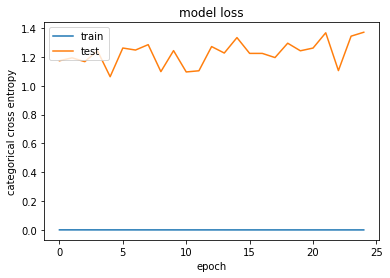

In [ ]:
print(type(predictions))
print(predictions.shape)

valgen = CustomDataGen(target_dict=training_gender_dict, 
                        metadata=metadata_test,
                        batch_size=224,
                        spectrogram_max_length=spectrogram_max_length,
                        number_of_mels=number_of_mels)

ground_truth_full = valgen.__getitem__(0)
ground_truth = ground_truth_full[1][0]

print("))))))))))))))))")
#print(ground_truth_full[1])
print(ground_truth.shape)
#print(type(ground_truth))

# print(predictions)

predictions_categorical = [np.argmax(predictions[ind,:]) for ind in range(predictions.shape[0])]
print(predictions_categorical)

#ground_truth_categorical = [np.argmax(ground_truth[1][ind,:]) for ind in range(ground_truth[1].shape[0])]
ground_truth_categorical = [np.argmax(ground_truth[ind,:]) for ind in range(ground_truth.shape[0])]
print(ground_truth_categorical)

confusion_matrix = np.zeros([2,2])
for index in range(len(predictions_categorical)):
  confusion_matrix[predictions_categorical[index], ground_truth_categorical[index]] += 1

print(confusion_matrix)
accuracy = (confusion_matrix[0,0] + confusion_matrix[1,1]) / sum(sum(confusion_matrix))
print(accuracy)



#Display performance

{'female': 0, 'male': 1}
dict_keys(['loss', 'val_loss'])
[0.0004382535407785326, 0.00040497069130651653, 0.0003702292451635003, 0.00034082483034580946, 0.00031339965062215924, 0.0002932299976237118, 0.00027164164930582047, 0.00025510613340884447, 0.0002382033853791654, 0.0002206069475505501, 0.00020832641166634858, 0.00020013029279652983, 0.00018731843738351017, 0.00017258305160794407, 0.00016314411186613142, 0.00015476987755391747, 0.00014652617392130196, 0.00013925945677328855, 0.00013261720596347004, 0.00012576853623613715, 0.00011990316852461547, 0.00011332514259265736, 9.648568811826408e-05, 0.00010396363359177485, 0.00010052306606667116]
[1.1735737323760986, 1.1937555074691772, 1.1673163175582886, 1.2429611682891846, 1.0629149675369263, 1.262008786201477, 1.2479760646820068, 1.2853275537490845, 1.0981029272079468, 1.2439630031585693, 1.0959903001785278, 1.1040568351745605, 1.272044062614441, 1.2272281646728516, 1.334326982498169, 1.2246818542480469, 1.2246190309524536, 1.19575142

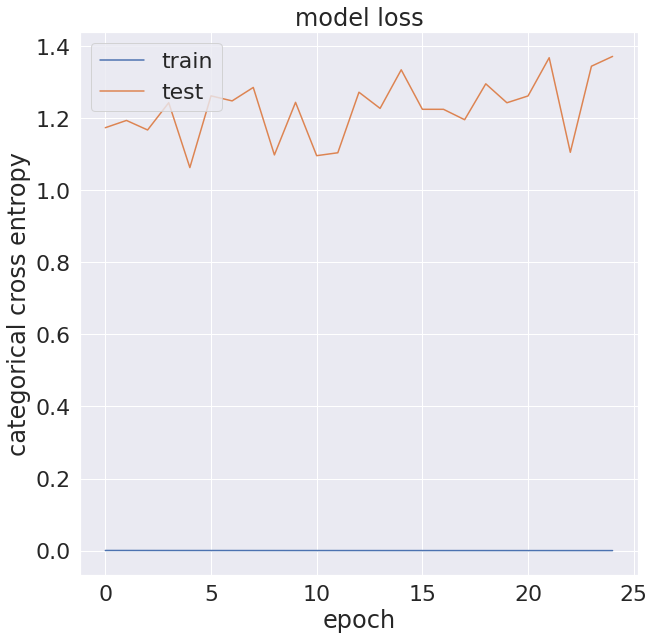

[[81. 24.]
 [28. 91.]]
[[81. 24.]
 [28. 91.]]
<class 'NoneType'>
(2, 2)


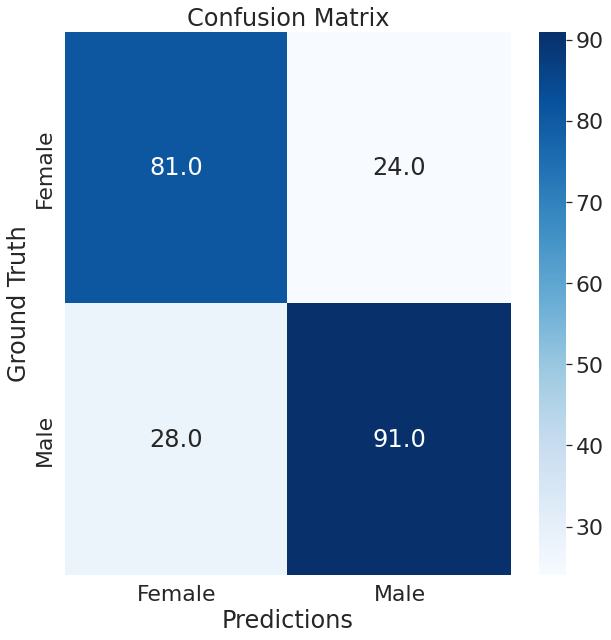

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sb


history = training_history

print(training_gender_dict)
# list all data in history
print(history.history.keys())
#['loss', 'val_loss']

print(history.history['loss'])
print(history.history['val_loss'])


# summarize history for accuracy
plt.figure(figsize=(10,10))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('categorical cross entropy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

confusion_matrix = np.zeros([2,2])
for index in range(len(predictions_categorical)):
  confusion_matrix[predictions_categorical[index], ground_truth_categorical[index]] += 1

print(confusion_matrix)
print(type(print(confusion_matrix)))
print(confusion_matrix.shape)

plt.figure(figsize=(10,10))
tick_labels = ['Female', 'Male']  
ax = sb.heatmap(confusion_matrix, 
                xticklabels=tick_labels, 
                yticklabels=tick_labels, 
                annot=True, 
                fmt='', 
                cmap='Blues')

#training_languages


ax.set(title="Confusion Matrix",
      xlabel="Predictions",
      ylabel="Ground Truth",)
 
sb.set(font_scale=2) # set fontsize 2

# Language Generators

In [98]:
#############
# Language Generator Definition
#############
traingen_language = CustomDataGen(target_dict=training_languages_dict, 
                          metadata=metadata_train,
                          target = 'language',
                          batch_size=32,
                          spectrogram_max_length=spectrogram_max_length,
                          number_of_mels=number_of_mels)


valgen_language = CustomDataGen(target_dict=training_languages_dict, 
                        metadata=metadata_test,
                        target = 'language',
                        batch_size=32,
                        spectrogram_max_length=spectrogram_max_length,
                        number_of_mels=number_of_mels)

# how many training batches in the full dataset?
print(metadata_train.shape)
print(metadata_test.shape)

(54, 10)
(36, 10)


# Language Model Definition

In [99]:
####################
# Language Model Definition
####################

from keras.layers.pooling import MaxPooling2D
from keras.layers.convolutional import Conv2D
import tensorflow as tf
from keras.models import Sequential
#from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Input, Bidirectional, LSTM, Dropout
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Softmax  
#from keras.layers.embeddings import Embedding
from keras.regularizers import l2
from keras.models import Model


model_language = Sequential()
model_language.add(Conv2D(6, 
                 (5, 5), 
                 activation='relu', 
                 input_shape=(spectrogram_max_length, 
                              number_of_mels, 
                              1)))
model_language.add(MaxPooling2D(2, 2))

model_language.add(Conv2D(16, 
                 (5, 5), 
                 activation='relu'))
model_language.add(MaxPooling2D(2, 2))

model_language.add(Flatten())

model_language.add(Dense(len(training_languages_dict)))
model_language.add(Softmax())

model_language.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy())

# Language Model Training

In [100]:
################################################
# Model Training
# Language Model
################################################
import os
model = None

language_model_filepath = './gdrive/MyDrive/Accent_Recognition/KerasModels/'
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    os.path.join(language_model_filepath,'checkpoint'), 
    monitor='val_loss', 
    verbose=0, 
    save_best_only=False, 
    save_weights_only=False, 
    mode='auto', 
    save_freq=16)

model = model_language
num_epochs = 50

print(num_epochs)
training_history = model.fit(traingen_language,
          validation_data=valgen_language,
          callbacks=[model_checkpoint_callback],
          epochs=num_epochs)


# # Save the weights
model.save(os.path.join(language_model_filepath,'LanguageModel'))

50


100%|██████████| 32/32 [00:00<00:00, 276.48it/s]


Epoch 1/50


100%|██████████| 32/32 [00:00<00:00, 273.16it/s]


1/1 [==============================] - ETA: 0s - loss: 2.2964

100%|██████████| 32/32 [00:00<00:00, 266.01it/s]


1/1 [==============================] - 2s 2s/step - loss: 2.2964 - val_loss: 24.1308
Epoch 2/50


100%|██████████| 32/32 [00:00<00:00, 269.31it/s]


1/1 [==============================] - ETA: 0s - loss: 20.6503

100%|██████████| 32/32 [00:00<00:00, 291.28it/s]


1/1 [==============================] - 1s 1s/step - loss: 20.6503 - val_loss: 25.8301
Epoch 3/50


100%|██████████| 32/32 [00:00<00:00, 240.41it/s]


1/1 [==============================] - ETA: 0s - loss: 12.5986

100%|██████████| 32/32 [00:00<00:00, 287.96it/s]


1/1 [==============================] - 1s 888ms/step - loss: 12.5986 - val_loss: 19.2557
Epoch 4/50


100%|██████████| 32/32 [00:00<00:00, 256.45it/s]


1/1 [==============================] - ETA: 0s - loss: 4.4797

100%|██████████| 32/32 [00:00<00:00, 280.57it/s]


1/1 [==============================] - 1s 883ms/step - loss: 4.4797 - val_loss: 10.7201
Epoch 5/50


100%|██████████| 32/32 [00:00<00:00, 281.41it/s]


1/1 [==============================] - ETA: 0s - loss: 0.2126

100%|██████████| 32/32 [00:00<00:00, 291.64it/s]


1/1 [==============================] - 1s 860ms/step - loss: 0.2126 - val_loss: 12.1165
Epoch 6/50


100%|██████████| 32/32 [00:00<00:00, 320.16it/s]


1/1 [==============================] - ETA: 0s - loss: 0.0322

100%|██████████| 32/32 [00:00<00:00, 284.12it/s]


1/1 [==============================] - 1s 1s/step - loss: 0.0322 - val_loss: 14.0573
Epoch 7/50


100%|██████████| 32/32 [00:00<00:00, 278.65it/s]


1/1 [==============================] - ETA: 0s - loss: 0.0632

100%|██████████| 32/32 [00:00<00:00, 272.58it/s]


1/1 [==============================] - 1s 1s/step - loss: 0.0632 - val_loss: 18.8562
Epoch 8/50


100%|██████████| 32/32 [00:00<00:00, 270.14it/s]


1/1 [==============================] - ETA: 0s - loss: 0.1069

100%|██████████| 32/32 [00:00<00:00, 283.56it/s]


1/1 [==============================] - 1s 863ms/step - loss: 0.1069 - val_loss: 18.9460
Epoch 9/50


100%|██████████| 32/32 [00:00<00:00, 286.93it/s]


1/1 [==============================] - ETA: 0s - loss: 0.2589

100%|██████████| 32/32 [00:00<00:00, 298.67it/s]


1/1 [==============================] - 1s 858ms/step - loss: 0.2589 - val_loss: 20.0268
Epoch 10/50


100%|██████████| 32/32 [00:00<00:00, 258.19it/s]


1/1 [==============================] - ETA: 0s - loss: 0.5531

100%|██████████| 32/32 [00:00<00:00, 278.84it/s]


1/1 [==============================] - 1s 879ms/step - loss: 0.5531 - val_loss: 21.1776
Epoch 11/50


100%|██████████| 32/32 [00:00<00:00, 270.12it/s]


1/1 [==============================] - ETA: 0s - loss: 0.3578

100%|██████████| 32/32 [00:00<00:00, 252.80it/s]


1/1 [==============================] - 1s 876ms/step - loss: 0.3578 - val_loss: 17.7078
Epoch 12/50


100%|██████████| 32/32 [00:00<00:00, 284.76it/s]


1/1 [==============================] - ETA: 0s - loss: 0.3411

100%|██████████| 32/32 [00:00<00:00, 277.04it/s]


1/1 [==============================] - 1s 882ms/step - loss: 0.3411 - val_loss: 18.7400
Epoch 13/50


100%|██████████| 32/32 [00:00<00:00, 268.52it/s]


1/1 [==============================] - ETA: 0s - loss: 0.3581

100%|██████████| 32/32 [00:00<00:00, 271.04it/s]


1/1 [==============================] - 1s 877ms/step - loss: 0.3581 - val_loss: 17.6133
Epoch 14/50


100%|██████████| 32/32 [00:00<00:00, 281.36it/s]


1/1 [==============================] - ETA: 0s - loss: 0.1689

100%|██████████| 32/32 [00:00<00:00, 283.27it/s]


1/1 [==============================] - 1s 858ms/step - loss: 0.1689 - val_loss: 16.8358
Epoch 15/50


100%|██████████| 32/32 [00:00<00:00, 264.37it/s]


1/1 [==============================] - ETA: 0s - loss: 0.1533

100%|██████████| 32/32 [00:00<00:00, 265.91it/s]


1/1 [==============================] - 1s 882ms/step - loss: 0.1533 - val_loss: 15.1664
Epoch 16/50


100%|██████████| 32/32 [00:00<00:00, 295.06it/s]


INFO:tensorflow:Assets written to: ./gdrive/MyDrive/Accent_Recognition/KerasModels/checkpoint/assets


INFO:tensorflow:Assets written to: ./gdrive/MyDrive/Accent_Recognition/KerasModels/checkpoint/assets


1/1 [==============================] - ETA: 0s - loss: 0.1407

100%|██████████| 32/32 [00:00<00:00, 307.09it/s]


1/1 [==============================] - 2s 2s/step - loss: 0.1407 - val_loss: 14.4961
Epoch 17/50


100%|██████████| 32/32 [00:00<00:00, 274.49it/s]


1/1 [==============================] - ETA: 0s - loss: 0.1239

100%|██████████| 32/32 [00:00<00:00, 281.94it/s]


1/1 [==============================] - 1s 870ms/step - loss: 0.1239 - val_loss: 13.6806
Epoch 18/50


100%|██████████| 32/32 [00:00<00:00, 281.16it/s]


1/1 [==============================] - ETA: 0s - loss: 0.1096

100%|██████████| 32/32 [00:00<00:00, 262.13it/s]


1/1 [==============================] - 1s 875ms/step - loss: 0.1096 - val_loss: 13.6763
Epoch 19/50


100%|██████████| 32/32 [00:00<00:00, 264.09it/s]


1/1 [==============================] - ETA: 0s - loss: 0.0046

100%|██████████| 32/32 [00:00<00:00, 294.74it/s]


1/1 [==============================] - 1s 881ms/step - loss: 0.0046 - val_loss: 12.3100
Epoch 20/50


100%|██████████| 32/32 [00:00<00:00, 275.74it/s]


1/1 [==============================] - ETA: 0s - loss: 0.0045

100%|██████████| 32/32 [00:00<00:00, 284.04it/s]


1/1 [==============================] - 1s 870ms/step - loss: 0.0045 - val_loss: 13.8685
Epoch 21/50


100%|██████████| 32/32 [00:00<00:00, 279.32it/s]


1/1 [==============================] - ETA: 0s - loss: 4.9475e-04

100%|██████████| 32/32 [00:00<00:00, 280.70it/s]


1/1 [==============================] - 1s 868ms/step - loss: 4.9475e-04 - val_loss: 12.8915
Epoch 22/50


100%|██████████| 32/32 [00:00<00:00, 268.73it/s]


1/1 [==============================] - ETA: 0s - loss: 0.0560

100%|██████████| 32/32 [00:00<00:00, 265.05it/s]


1/1 [==============================] - 1s 912ms/step - loss: 0.0560 - val_loss: 12.7053
Epoch 23/50


100%|██████████| 32/32 [00:00<00:00, 274.97it/s]


1/1 [==============================] - ETA: 0s - loss: 0.0472

100%|██████████| 32/32 [00:00<00:00, 277.41it/s]


1/1 [==============================] - 1s 888ms/step - loss: 0.0472 - val_loss: 12.0077
Epoch 24/50


100%|██████████| 32/32 [00:00<00:00, 278.21it/s]


1/1 [==============================] - ETA: 0s - loss: 0.0028

100%|██████████| 32/32 [00:00<00:00, 276.32it/s]


1/1 [==============================] - 1s 871ms/step - loss: 0.0028 - val_loss: 12.3005
Epoch 25/50


100%|██████████| 32/32 [00:00<00:00, 275.86it/s]


1/1 [==============================] - ETA: 0s - loss: 0.0293

100%|██████████| 32/32 [00:00<00:00, 266.40it/s]


1/1 [==============================] - 1s 886ms/step - loss: 0.0293 - val_loss: 11.5645
Epoch 26/50


100%|██████████| 32/32 [00:00<00:00, 242.90it/s]


1/1 [==============================] - ETA: 0s - loss: 0.0237

100%|██████████| 32/32 [00:00<00:00, 292.93it/s]


1/1 [==============================] - 1s 898ms/step - loss: 0.0237 - val_loss: 11.2852
Epoch 27/50


100%|██████████| 32/32 [00:00<00:00, 273.57it/s]


1/1 [==============================] - ETA: 0s - loss: 0.0177

100%|██████████| 32/32 [00:00<00:00, 269.98it/s]


1/1 [==============================] - 1s 892ms/step - loss: 0.0177 - val_loss: 11.4444
Epoch 28/50


100%|██████████| 32/32 [00:00<00:00, 274.26it/s]


1/1 [==============================] - ETA: 0s - loss: 0.0016

100%|██████████| 32/32 [00:00<00:00, 288.03it/s]


1/1 [==============================] - 1s 880ms/step - loss: 0.0016 - val_loss: 11.1085
Epoch 29/50


100%|██████████| 32/32 [00:00<00:00, 268.79it/s]


1/1 [==============================] - ETA: 0s - loss: 7.3333e-04

100%|██████████| 32/32 [00:00<00:00, 197.50it/s]


1/1 [==============================] - 1s 1s/step - loss: 7.3333e-04 - val_loss: 10.2488
Epoch 30/50


100%|██████████| 32/32 [00:00<00:00, 306.75it/s]


1/1 [==============================] - ETA: 0s - loss: 0.0012

100%|██████████| 32/32 [00:00<00:00, 284.18it/s]


1/1 [==============================] - 1s 892ms/step - loss: 0.0012 - val_loss: 11.2557
Epoch 31/50


100%|██████████| 32/32 [00:00<00:00, 288.57it/s]


1/1 [==============================] - ETA: 0s - loss: 0.0041

100%|██████████| 32/32 [00:00<00:00, 286.40it/s]


1/1 [==============================] - 1s 862ms/step - loss: 0.0041 - val_loss: 10.5621
Epoch 32/50


100%|██████████| 32/32 [00:00<00:00, 254.20it/s]


INFO:tensorflow:Assets written to: ./gdrive/MyDrive/Accent_Recognition/KerasModels/checkpoint/assets


INFO:tensorflow:Assets written to: ./gdrive/MyDrive/Accent_Recognition/KerasModels/checkpoint/assets


1/1 [==============================] - ETA: 0s - loss: 0.0012

100%|██████████| 32/32 [00:00<00:00, 279.27it/s]


1/1 [==============================] - 2s 2s/step - loss: 0.0012 - val_loss: 11.2538
Epoch 33/50


100%|██████████| 32/32 [00:00<00:00, 266.11it/s]


1/1 [==============================] - ETA: 0s - loss: 0.0024

100%|██████████| 32/32 [00:00<00:00, 285.70it/s]


1/1 [==============================] - 1s 1s/step - loss: 0.0024 - val_loss: 9.9275
Epoch 34/50


100%|██████████| 32/32 [00:00<00:00, 266.42it/s]


1/1 [==============================] - ETA: 0s - loss: 7.4647e-04

100%|██████████| 32/32 [00:00<00:00, 276.45it/s]


1/1 [==============================] - 1s 878ms/step - loss: 7.4647e-04 - val_loss: 10.0291
Epoch 35/50


100%|██████████| 32/32 [00:00<00:00, 283.51it/s]


1/1 [==============================] - ETA: 0s - loss: 5.7391e-04

100%|██████████| 32/32 [00:00<00:00, 284.86it/s]


1/1 [==============================] - 1s 874ms/step - loss: 5.7391e-04 - val_loss: 9.1917
Epoch 36/50


100%|██████████| 32/32 [00:00<00:00, 269.17it/s]


1/1 [==============================] - ETA: 0s - loss: 1.6578e-04

100%|██████████| 32/32 [00:00<00:00, 284.66it/s]


1/1 [==============================] - 1s 868ms/step - loss: 1.6578e-04 - val_loss: 9.5235
Epoch 37/50


100%|██████████| 32/32 [00:00<00:00, 277.83it/s]


1/1 [==============================] - ETA: 0s - loss: 5.6394e-04

100%|██████████| 32/32 [00:00<00:00, 321.22it/s]


1/1 [==============================] - 1s 1s/step - loss: 5.6394e-04 - val_loss: 9.9022
Epoch 38/50


100%|██████████| 32/32 [00:00<00:00, 279.11it/s]


1/1 [==============================] - ETA: 0s - loss: 4.7138e-04

100%|██████████| 32/32 [00:00<00:00, 289.21it/s]


1/1 [==============================] - 1s 1s/step - loss: 4.7138e-04 - val_loss: 9.2371
Epoch 39/50


100%|██████████| 32/32 [00:00<00:00, 319.59it/s]


1/1 [==============================] - ETA: 0s - loss: 6.7869e-04

100%|██████████| 32/32 [00:00<00:00, 287.89it/s]


1/1 [==============================] - 1s 1s/step - loss: 6.7869e-04 - val_loss: 10.2320
Epoch 40/50


100%|██████████| 32/32 [00:00<00:00, 242.68it/s]


1/1 [==============================] - ETA: 0s - loss: 3.2093e-04

100%|██████████| 32/32 [00:00<00:00, 251.95it/s]


1/1 [==============================] - 1s 1s/step - loss: 3.2093e-04 - val_loss: 8.9813
Epoch 41/50


100%|██████████| 32/32 [00:00<00:00, 197.15it/s]


1/1 [==============================] - ETA: 0s - loss: 4.9750e-04

100%|██████████| 32/32 [00:00<00:00, 226.93it/s]


1/1 [==============================] - 1s 1s/step - loss: 4.9750e-04 - val_loss: 8.8531
Epoch 42/50


100%|██████████| 32/32 [00:00<00:00, 128.54it/s]


1/1 [==============================] - ETA: 0s - loss: 8.9547e-05

100%|██████████| 32/32 [00:00<00:00, 215.17it/s]


1/1 [==============================] - 1s 1s/step - loss: 8.9547e-05 - val_loss: 7.5590
Epoch 43/50


100%|██████████| 32/32 [00:00<00:00, 236.30it/s]


1/1 [==============================] - ETA: 0s - loss: 5.2375e-04

100%|██████████| 32/32 [00:00<00:00, 217.49it/s]


1/1 [==============================] - 1s 988ms/step - loss: 5.2375e-04 - val_loss: 8.2650
Epoch 44/50


100%|██████████| 32/32 [00:00<00:00, 212.58it/s]


1/1 [==============================] - ETA: 0s - loss: 4.2756e-04

100%|██████████| 32/32 [00:00<00:00, 205.72it/s]


1/1 [==============================] - 1s 1s/step - loss: 4.2756e-04 - val_loss: 9.6421
Epoch 45/50


100%|██████████| 32/32 [00:00<00:00, 190.34it/s]


1/1 [==============================] - ETA: 0s - loss: 1.5396e-04

100%|██████████| 32/32 [00:00<00:00, 225.18it/s]


1/1 [==============================] - 1s 1s/step - loss: 1.5396e-04 - val_loss: 8.7383
Epoch 46/50


100%|██████████| 32/32 [00:00<00:00, 217.06it/s]


1/1 [==============================] - ETA: 0s - loss: 3.7856e-04

100%|██████████| 32/32 [00:00<00:00, 215.94it/s]


1/1 [==============================] - 1s 1s/step - loss: 3.7856e-04 - val_loss: 8.9328
Epoch 47/50


100%|██████████| 32/32 [00:00<00:00, 201.28it/s]


1/1 [==============================] - ETA: 0s - loss: 5.6283e-04

100%|██████████| 32/32 [00:00<00:00, 263.44it/s]


1/1 [==============================] - 1s 968ms/step - loss: 5.6283e-04 - val_loss: 8.6289
Epoch 48/50


100%|██████████| 32/32 [00:00<00:00, 258.74it/s]


INFO:tensorflow:Assets written to: ./gdrive/MyDrive/Accent_Recognition/KerasModels/checkpoint/assets


INFO:tensorflow:Assets written to: ./gdrive/MyDrive/Accent_Recognition/KerasModels/checkpoint/assets


1/1 [==============================] - ETA: 0s - loss: 9.3128e-05

100%|██████████| 32/32 [00:00<00:00, 272.83it/s]


1/1 [==============================] - 2s 2s/step - loss: 9.3128e-05 - val_loss: 7.8262
Epoch 49/50


100%|██████████| 32/32 [00:00<00:00, 256.40it/s]


1/1 [==============================] - ETA: 0s - loss: 1.1300e-04

100%|██████████| 32/32 [00:00<00:00, 277.71it/s]


1/1 [==============================] - 1s 1s/step - loss: 1.1300e-04 - val_loss: 8.9102
Epoch 50/50


100%|██████████| 32/32 [00:00<00:00, 264.68it/s]


1/1 [==============================] - ETA: 0s - loss: 2.3810e-04

100%|██████████| 32/32 [00:00<00:00, 275.39it/s]


1/1 [==============================] - 1s 882ms/step - loss: 2.3810e-04 - val_loss: 9.2734
INFO:tensorflow:Assets written to: ./gdrive/MyDrive/Accent_Recognition/KerasModels/LanguageModel/assets


INFO:tensorflow:Assets written to: ./gdrive/MyDrive/Accent_Recognition/KerasModels/LanguageModel/assets


# Get Predictions

In [101]:

from sklearn.metrics import confusion_matrix
import seaborn as sb

####################
# get ground truth
####################

valgen_language = CustomDataGen(target_dict=training_languages_dict, 
                        metadata=metadata_test,
                        target = 'language',
                        batch_size=metadata_test.shape[0],
                        spectrogram_max_length=spectrogram_max_length,
                        number_of_mels=number_of_mels)

ground_truth_full = valgen_language.__getitem__(0)
ground_truth = ground_truth_full[1][0]

#ground_truth_categorical = [np.argmax(ground_truth[1][ind,:]) for ind in range(ground_truth[1].shape[0])]
ground_truth_categorical = [np.argmax(ground_truth[ind,:]) for 
                            ind in range(ground_truth.shape[0])]


valgen_language = CustomDataGen(target_dict=training_languages_dict, 
                        metadata=metadata_test,
                        target = 'language',
                        batch_size=1,
                        spectrogram_max_length=spectrogram_max_length,
                        number_of_mels=number_of_mels)



####################
# generate predictions
####################


predictions = model.predict(valgen_language)

predictions_categorical = [np.argmax(predictions[ind,:]) for 
                           ind in range(predictions.shape[0])]
# print(predictions_categorical)


# print("\n")
# print("")                            
# print(ground_truth_categorical)
# print(len(ground_truth_categorical))

100%|██████████| 1/1 [00:00<00:00, 129.76it/s]


[6, 3, 3, 3, 7, 7, 6, 7, 6, 3, 7, 4, 3, 7, 3, 3, 4, 3, 3, 3, 7, 6, 4, 6, 4, 4, 6, 3, 6, 7, 7, 7, 4, 8, 4, 4]



[5, 5, 5, 5, 0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 6, 6, 6, 6, 4, 4, 4, 4, 7, 7, 7, 7, 8, 8, 8, 8]
36


# Display Loss History

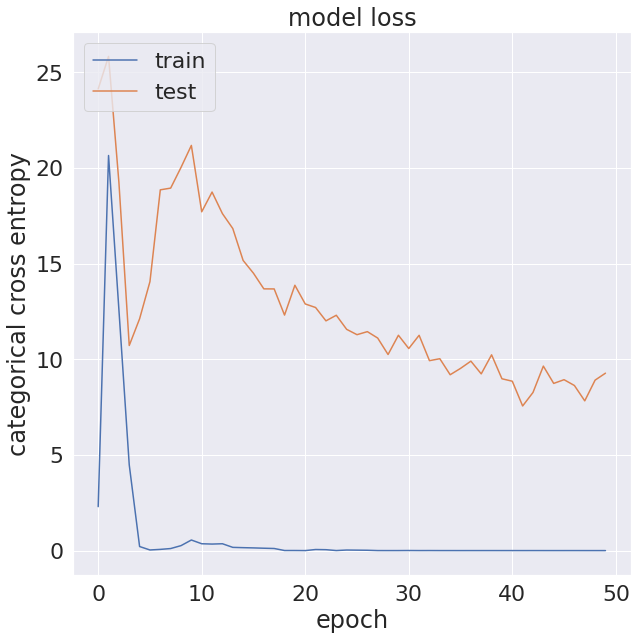

In [102]:
####################
# display loss history
####################

import seaborn as sb

history = training_history

plt.figure(figsize=(10,10))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('categorical cross entropy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# # Save the weights
# model.save_weights('./checkpoints/my_checkpoint')

# # Create a new model instance
# model = create_model()

# # Restore the weights
# model.load_weights('./checkpoints/my_checkpoint')

# # Evaluate the model
# loss, acc = model.evaluate(test_images, test_labels, verbose=2)
# print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

#Display confusion Matrix

           values
arabic        0.0
bengali       0.0
bulgarian     0.0
cantonese     3.0
english       2.0
amharic       0.0
dutch         2.0
farsi         3.0
french        1.0
Accuracy : 0.3055555555555556
Chance Accuracy would be 0.1111111111111111
Finished


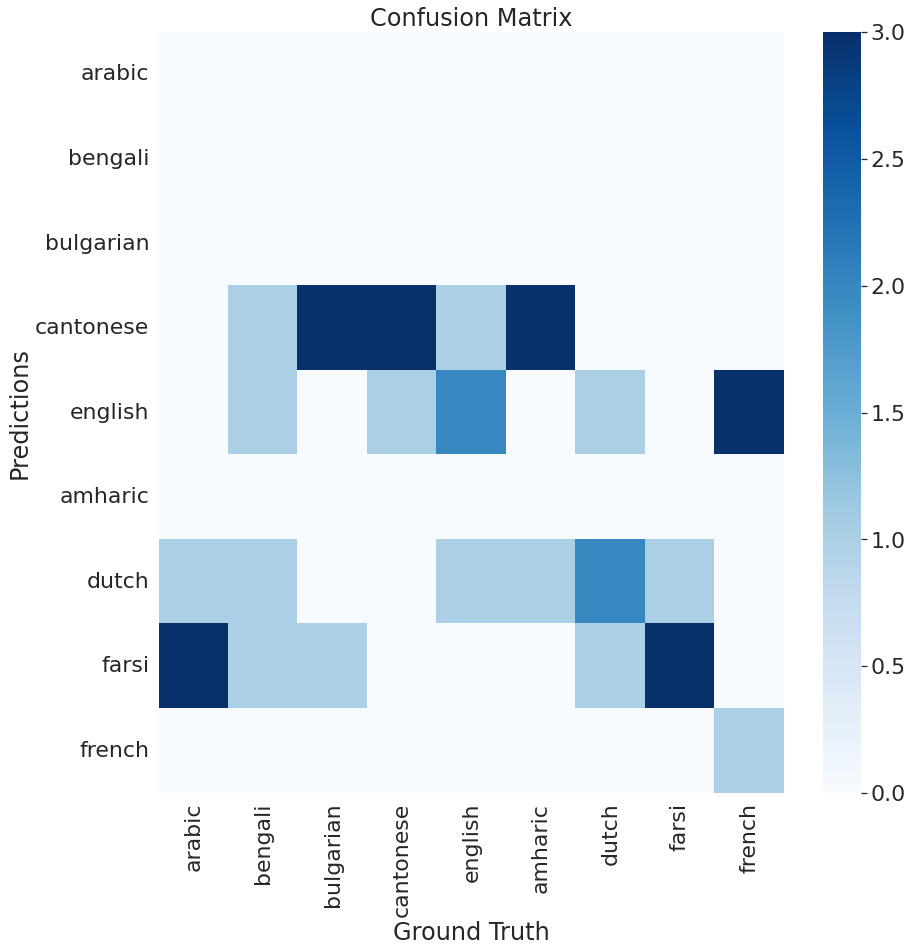

In [107]:
####################
# display confusion matrix
####################

from sklearn.metrics import confusion_matrix

preds_df = pd.DataFrame({'GroundTruth': ground_truth_categorical, 'Predictions':predictions_categorical})
# print(preds_df)
num_categories = len(training_languages_dict)
confusion_matrix = np.zeros([num_categories,num_categories])
for index in range(len(predictions_categorical)):
  confusion_matrix[predictions_categorical[index], ground_truth_categorical[index]] += 1

plt.figure(figsize=(14,14))
tick_labels = list(training_languages_dict.keys())
ax = sb.heatmap(confusion_matrix, 
                xticklabels=tick_labels, 
                yticklabels=tick_labels, 
                annot=False, 
                fmt='', 
                cmap='Blues')

ax.set(title="Confusion Matrix",
      ylabel="Predictions",
      xlabel="Ground Truth",)
 
sb.set(font_scale=2) # set fontsize 2

cm_diag=[confusion_matrix[ind,ind] for ind in range(confusion_matrix.shape[0])]
cm_diag_df = pd.DataFrame({'values':cm_diag},index=tick_labels)

# Convert the whole dataframe as a string and display
# The scope of these changes made to
# pandas settings are local to with statement.
print("Diagonal elemets of the confusion matrix:")
with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.precision', 3,
                       ):
    print(cm_diag_df)

print(f"Accuracy : {sum(cm_diag)/sum(sum(confusion_matrix))}")
print(f"Chance Accuracy would be {1./len(cm_diag)}")
print("Finished")